In [1]:
import sys

sys.path.insert(0, '../')

from modules.VT_dataset import *
from modules.train_prep import *
from modules.plot_results import *

In [2]:
class EEGCNN(nn.Module):
    def __init__(self, num_classes=4):
        # Initialize the EEGCNN class as a subclass of nn.Module.
        super(EEGCNN, self).__init__()

        # First convolutional layer with 16 filters, kernel size of (3, 40), and padding to preserve the time dimension.
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 40), padding=(1, 20))
        # Batch normalization for the first convolutional layer to stabilize learning.
        self.bn1 = nn.BatchNorm2d(16)

        # Second convolutional layer with 32 filters, kernel size of (3, 25), and padding to preserve the time dimension.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 25), padding=(1, 12))
        # Batch normalization for the second convolutional layer.
        self.bn2 = nn.BatchNorm2d(32)

        # Third convolutional layer with 64 filters, kernel size of (3, 10), and padding to preserve the time dimension.
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 10), padding=(1, 5))
        # Batch normalization for the third convolutional layer.
        self.bn3 = nn.BatchNorm2d(64)

        # Max pooling layer to reduce the spatial dimensions of the output from convolutional layers.
        self.pool = nn.MaxPool2d((2, 4))

        # Dropout layer with 0.25 probability, used to prevent overfitting by randomly zeroing some of the elements.
        self.dropout1 = nn.Dropout(0.25)
        # Another dropout layer with a higher dropout rate of 0.5.
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layer to reduce the dimension from the flattened output to 100.
        self.fc1 = nn.Linear(19456, 100)  # 64 channels * 17 height * 20 width = 19456
        # Second fully connected layer that maps the 100 features to the number of classes.
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        # Define the forward pass through the network.
        x = x.unsqueeze(1)  # Add a channel dimension to the input if needed (for greyscale images).

        # First convolutional layer followed by batch normalization, a leaky ReLU activation, and pooling.
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        # Second convolutional layer followed by batch normalization, a leaky ReLU activation, and pooling.
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Third convolutional layer followed by batch normalization, a leaky ReLU activation, and pooling.
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        # Apply the first dropout layer.
        x = self.dropout1(x)
        
        # Flatten the output of the last pooling layer to prepare it for the fully connected layer.
        x = torch.flatten(x, 1)

        # Fully connected layer with a leaky ReLU activation.
        x = F.leaky_relu(self.fc1(x))

        # Apply the second dropout layer before the final fully connected layer.
        x = self.dropout2(x)

        # Final fully connected layer that outputs the predictions.
        x = self.fc2(x)
        
        return x

In [3]:
# Check and set the appropriate device (GPU or MPS) based on availability.
if torch.cuda.is_available():
    torch.cuda.set_device(cuda_device)  # Set the specific GPU device if CUDA is available.
elif torch.backends.mps.is_available():
    mps_device = torch.device("mps")  # Set the MPS device for Apple Silicon chips if available.

# Define transformations to apply to training and validation datasets. Currently, it converts images to PyTorch tensors.
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),  # Convert images to tensor format.
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),  # Convert images to tensor format.
    ]),
}

# Initialize datasets for training and validation using the specified directories and behavioral files.
dsets = {
    'train': RawDataset(train_dir, train_behav_file, data_transforms['train']),
    'val': RawDataset(val_dir, val_behav_file, data_transforms['val'])
}
# Calculate the number of samples in each dataset.
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}

# Initialize data loaders for training and validation, configuring class balancing via weighted sampling.
dset_loaders = {}
for split in ['train', 'val']:
    # Extract labels for all entries in the dataset to calculate class weights.
    targets = np.array([dsets[split].get_label(i) for i in range(len(dsets[split]))])
    # Count occurrences of each class to address class imbalance.
    class_counts = dsets[split].get_class_counts()
    # Compute weights for each sample, inversely proportional to class frequency.
    class_weights = np.array([1.0 / class_counts[label] if class_counts[label] > 0 else 0 for label in targets])
    # Create a sampler for weighted sampling, which helps in dealing with imbalanced data by adjusting the likelihood of sample selection.
    sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)
    # Define the DataLoader for each dataset split, using the custom sampler and specifying batch size and number of workers.
    dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=b_size, num_workers=0, sampler=sampler)
    # Confirmation message to indicate completion of DataLoader setup for each dataset split.
    print('done making loader:', split)

# Initialize the EEGCNN model, specifying the number of classes for the output layer.
model_ft = EEGCNN(num_classes=4)
# Define the loss function, using cross-entropy loss which is common for classification tasks.
criterion = nn.CrossEntropyLoss()
# Configure the optimizer, using Adam algorithm with a specified learning rate and weight decay for regularization.
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-5)

# Determine the device to train on, prioritizing CUDA (GPU), MPS (Apple Silicon), or defaulting to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# Move the model and loss function to the chosen device to enable GPU/MPS acceleration.
model_ft.to(device)
criterion.to(device)
# Print the device being used for training to confirm the setup.
print(f"Training on {device}")

# Function call to train the model, passing the model, loss function, optimizer, learning rate scheduler, data loaders, dataset sizes, and number of epochs.
# This function presumably handles the entire training process including forward and backward passes, and learning rate adjustments.
model_ft, accuracies, losses, preds, labels = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dset_loaders, dset_sizes, num_epochs=n_epochs)


  0%|                                                                                                                                                                                     | 0/192 [00:00<?, ?it/s]


  2%|███▌                                                                                                                                                                         | 4/192 [00:00<00:04, 37.97it/s]


  4%|███████▏                                                                                                                                                                     | 8/192 [00:00<00:05, 33.95it/s]


  6%|██████████▊                                                                                                                                                                 | 12/192 [00:00<00:05, 33.63it/s]


  8%|██████████████▎                                                                                                                                                             | 16/192 [00:00<00:05, 33.09it/s]


 10%|█████████████████▉                                                                                                                                                          | 20/192 [00:00<00:05, 31.75it/s]


 12%|█████████████████████▌                                                                                                                                                      | 24/192 [00:00<00:05, 31.91it/s]


 15%|█████████████████████████                                                                                                                                                   | 28/192 [00:00<00:05, 30.87it/s]


 17%|████████████████████████████▋                                                                                                                                               | 32/192 [00:01<00:05, 30.82it/s]


 19%|████████████████████████████████▎                                                                                                                                           | 36/192 [00:01<00:05, 30.44it/s]


 21%|███████████████████████████████████▊                                                                                                                                        | 40/192 [00:01<00:05, 30.15it/s]


 23%|███████████████████████████████████████▍                                                                                                                                    | 44/192 [00:01<00:04, 31.39it/s]


 25%|███████████████████████████████████████████                                                                                                                                 | 48/192 [00:01<00:04, 30.56it/s]


 27%|██████████████████████████████████████████████▌                                                                                                                             | 52/192 [00:01<00:04, 31.37it/s]


 29%|██████████████████████████████████████████████████▏                                                                                                                         | 56/192 [00:01<00:04, 31.94it/s]


 31%|█████████████████████████████████████████████████████▊                                                                                                                      | 60/192 [00:01<00:03, 33.74it/s]


 33%|█████████████████████████████████████████████████████████▎                                                                                                                  | 64/192 [00:02<00:04, 31.80it/s]


 35%|████████████████████████████████████████████████████████████▉                                                                                                               | 68/192 [00:02<00:03, 32.29it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                           | 72/192 [00:02<00:03, 34.19it/s]


 40%|████████████████████████████████████████████████████████████████████                                                                                                        | 76/192 [00:02<00:03, 32.65it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                    | 80/192 [00:02<00:03, 33.54it/s]


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                                | 84/192 [00:02<00:03, 31.99it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                             | 88/192 [00:02<00:03, 31.31it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 92/192 [00:02<00:03, 31.35it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 96/192 [00:03<00:03, 31.96it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 100/192 [00:03<00:02, 31.19it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 104/192 [00:03<00:02, 31.05it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 108/192 [00:03<00:02, 30.60it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 112/192 [00:03<00:02, 30.48it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 116/192 [00:03<00:02, 30.66it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 120/192 [00:03<00:02, 30.26it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 124/192 [00:03<00:02, 30.08it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 128/192 [00:04<00:02, 30.37it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 132/192 [00:04<00:02, 29.95it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 135/192 [00:04<00:01, 29.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 139/192 [00:04<00:01, 30.31it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 143/192 [00:04<00:01, 29.87it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 146/192 [00:04<00:01, 29.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 149/192 [00:04<00:01, 29.39it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 152/192 [00:04<00:01, 29.02it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 155/192 [00:04<00:01, 28.99it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 158/192 [00:05<00:01, 29.03it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 161/192 [00:05<00:01, 28.88it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 165/192 [00:05<00:00, 29.43it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 169/192 [00:05<00:00, 29.52it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 172/192 [00:05<00:00, 29.32it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 176/192 [00:05<00:00, 29.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 179/192 [00:05<00:00, 29.11it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 182/192 [00:05<00:00, 29.12it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 185/192 [00:06<00:00, 28.95it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 188/192 [00:06<00:00, 29.24it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 191/192 [00:06<00:00, 28.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:06<00:00, 30.70it/s]

Class counts:  {'HEHF': 2489, 'HELF': 238, 'LEHF': 1371, 'LELF': 878}



  0%|                                                                                                                                                                                      | 0/48 [00:00<?, ?it/s]


  6%|██████████▉                                                                                                                                                                   | 3/48 [00:00<00:01, 25.56it/s]


 12%|█████████████████████▊                                                                                                                                                        | 6/48 [00:00<00:01, 27.88it/s]


 19%|████████████████████████████████▋                                                                                                                                             | 9/48 [00:00<00:01, 27.78it/s]


 25%|███████████████████████████████████████████▎                                                                                                                                 | 12/48 [00:00<00:01, 27.54it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                       | 15/48 [00:00<00:01, 27.74it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                            | 18/48 [00:00<00:01, 28.46it/s]


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                 | 21/48 [00:00<00:00, 27.94it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 24/48 [00:00<00:01, 19.96it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 27/48 [00:01<00:00, 21.77it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 31/48 [00:01<00:00, 24.50it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 34/48 [00:01<00:00, 25.57it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 37/48 [00:01<00:00, 26.42it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 40/48 [00:01<00:00, 27.17it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 44/48 [00:01<00:00, 28.43it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 47/48 [00:01<00:00, 28.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 26.43it/s]

Class counts:  {'HEHF': 508, 'HELF': 101, 'LEHF': 535, 'LELF': 100}
done making loader: train
done making loader: val
Training on mps



  0%|                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s]

----------
Epoch 0/4
----------
LR is set to 0.0001

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:02<24:33,  1.68it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:03<11:35,  3.56it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:03<07:18,  5.64it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:03<05:15,  7.83it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:04<04:03, 10.09it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:04<03:16, 12.48it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:04<02:50, 14.40it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:04<02:32, 16.07it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:04<02:18, 17.61it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:05<02:04, 19.54it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:05<01:59, 20.36it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:05<01:57, 20.59it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:05<01:53, 21.33it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:06<01:57, 20.53it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:06<01:56, 20.72it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:06<01:49, 21.97it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:06<01:50, 21.78it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:07<01:56, 20.63it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:07<01:52, 21.20it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:07<01:47, 22.12it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:07<01:45, 22.66it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:07<01:41, 23.32it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:08<01:38, 24.18it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:08<01:39, 23.90it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:08<01:39, 23.65it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:08<01:39, 23.74it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:08<01:45, 22.31it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:09<01:45, 22.17it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:09<01:39, 23.52it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:09<01:37, 23.90it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:09<01:36, 24.14it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:09<01:39, 23.41it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:10<01:37, 23.83it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:10<01:37, 23.88it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:10<01:38, 23.41it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:10<01:37, 23.68it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:11<01:37, 23.51it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:11<01:37, 23.60it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:11<01:41, 22.59it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:11<01:39, 23.00it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:11<01:39, 23.04it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:12<01:38, 23.12it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:12<01:37, 23.38it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:12<01:40, 22.67it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:12<01:35, 23.74it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:12<01:33, 24.27it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:13<01:33, 23.97it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:13<01:30, 24.73it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:13<01:32, 24.28it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:13<01:29, 25.09it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:13<01:28, 25.33it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:14<01:29, 24.97it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:14<01:27, 25.39it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:14<01:29, 24.73it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:14<01:28, 24.98it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:14<01:33, 23.74it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:15<01:29, 24.55it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:15<01:26, 25.38it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:15<01:24, 26.02it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:15<01:22, 26.50it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:15<01:23, 26.24it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:16<01:24, 25.86it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:16<01:24, 25.78it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:16<01:23, 26.01it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:16<01:23, 25.91it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:16<01:23, 25.83it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:17<01:26, 24.76it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:17<01:30, 23.80it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:17<01:29, 23.91it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:17<01:29, 23.90it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:17<01:27, 24.43it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:18<01:27, 24.29it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:18<01:24, 25.17it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:18<01:25, 24.80it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:18<01:26, 24.53it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:18<01:25, 24.62it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:19<01:25, 24.70it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:19<01:26, 24.28it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:19<01:24, 24.88it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:19<01:22, 25.37it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:19<01:22, 25.24it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:20<01:21, 25.62it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:20<01:21, 25.43it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:20<01:21, 25.45it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:20<01:19, 25.85it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:20<01:21, 25.20it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:21<01:22, 24.86it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:21<01:22, 24.83it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:21<01:20, 25.32it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:21<01:20, 25.22it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:21<01:19, 25.68it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:22<01:21, 24.84it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:22<01:23, 24.29it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:22<01:23, 24.28it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:22<01:20, 24.90it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:22<01:18, 25.67it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:23<01:16, 26.26it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:23<01:15, 26.38it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:23<01:16, 26.14it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:23<01:17, 25.78it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:23<01:16, 26.03it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:24<01:15, 26.17it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:24<01:14, 26.33it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:24<01:15, 26.14it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:24<01:21, 23.95it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:24<01:19, 24.68it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:25<01:20, 24.21it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:25<01:19, 24.63it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:25<01:18, 24.73it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:25<01:18, 24.77it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:25<01:17, 25.04it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:26<01:14, 25.73it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:26<01:13, 26.27it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:26<01:12, 26.44it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:26<01:12, 26.46it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:26<01:12, 26.23it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:27<01:13, 25.82it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:27<01:13, 25.81it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:27<01:14, 25.26it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:27<01:13, 25.83it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:27<01:11, 26.38it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:27<01:12, 25.91it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:28<01:13, 25.60it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:28<01:13, 25.30it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:28<01:13, 25.45it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:28<01:11, 25.84it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:28<01:11, 25.78it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:29<01:11, 26.01it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:29<01:12, 25.41it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:29<01:12, 25.24it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:29<01:13, 24.78it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:29<01:11, 25.59it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:30<01:10, 25.69it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:30<01:10, 25.90it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:30<01:10, 25.87it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:30<01:08, 26.40it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:30<01:09, 25.90it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:31<01:09, 25.85it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:31<01:12, 24.70it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:31<01:10, 25.28it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:31<01:08, 25.99it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:31<01:09, 25.64it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:32<01:08, 25.86it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:32<01:10, 25.05it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:32<01:09, 25.19it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:32<01:08, 25.64it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:32<01:05, 26.80it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:33<01:06, 26.44it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:33<01:06, 26.25it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:33<01:08, 25.54it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:33<01:07, 25.82it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:33<01:06, 25.83it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:34<01:06, 25.74it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:34<01:06, 25.74it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:34<01:04, 26.58it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:34<01:04, 26.36it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:34<01:03, 27.03it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:34<01:05, 26.04it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:35<01:06, 25.41it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:35<01:04, 25.99it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:35<01:04, 25.92it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:35<01:04, 26.13it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:35<01:03, 26.35it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:36<01:04, 25.86it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:36<01:05, 25.22it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:36<01:05, 25.12it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:36<01:03, 26.11it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:36<01:02, 26.55it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:37<01:01, 26.90it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:37<01:01, 26.85it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:37<01:00, 27.04it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:37<01:03, 25.79it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:37<01:02, 26.07it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:38<01:01, 26.23it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:38<01:01, 26.32it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:38<01:00, 26.76it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:38<01:01, 25.89it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:38<01:03, 25.26it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:39<01:01, 25.89it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:39<01:01, 25.84it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:39<00:59, 26.67it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:39<01:00, 26.15it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:39<01:01, 25.65it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:39<00:59, 26.54it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:40<00:59, 26.24it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:40<00:59, 26.18it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:40<01:01, 25.45it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:40<01:00, 25.79it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:40<01:00, 25.49it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:41<01:00, 25.29it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:41<01:00, 25.44it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:41<01:00, 25.46it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:41<00:59, 25.80it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:41<00:58, 26.13it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:42<00:57, 26.20it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:42<00:59, 25.53it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:42<00:58, 25.61it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:42<00:58, 25.64it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:42<00:58, 25.40it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:43<01:00, 24.68it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:43<00:58, 25.19it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:43<00:59, 24.79it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:43<00:58, 25.12it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:43<00:59, 24.73it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:44<00:58, 25.11it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:44<00:57, 25.24it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:44<00:56, 25.60it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:44<00:55, 26.01it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:44<00:57, 25.25it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:45<00:56, 25.42it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:45<00:57, 24.78it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:45<00:55, 25.50it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:45<00:55, 25.85it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:45<00:54, 25.85it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:46<00:51, 27.21it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:46<00:52, 27.04it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:46<00:51, 27.27it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:46<00:52, 26.83it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:46<00:52, 26.39it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:46<00:52, 26.21it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:47<00:53, 25.78it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:47<00:52, 26.31it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:47<00:55, 24.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:47<00:55, 24.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:47<00:53, 25.52it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:48<00:52, 25.91it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:48<00:52, 25.60it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:48<00:51, 26.16it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:48<00:53, 25.21it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:48<00:55, 24.25it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:49<00:58, 22.88it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:49<00:59, 22.32it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:49<00:56, 23.24it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:49<00:55, 23.89it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:50<00:54, 24.19it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:50<00:53, 24.67it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:50<00:53, 24.20it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:50<00:55, 23.59it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:50<00:54, 23.70it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:51<00:54, 23.60it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:51<00:52, 24.42it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:51<00:51, 24.84it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:51<00:52, 24.34it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:51<00:50, 24.92it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:52<00:49, 25.69it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:52<00:50, 24.90it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:52<00:49, 25.18it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:52<00:49, 25.04it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:52<00:47, 26.35it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:53<00:47, 25.84it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:53<00:46, 26.73it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:53<00:47, 25.85it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:53<00:48, 25.22it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:53<00:46, 26.27it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:54<00:46, 26.07it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:54<00:49, 24.61it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:54<00:48, 24.89it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:54<00:47, 25.12it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:54<00:46, 25.55it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:55<00:47, 25.08it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:55<00:45, 25.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:55<00:45, 26.07it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:55<00:46, 25.43it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:55<00:45, 25.50it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:55<00:46, 25.26it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:56<00:43, 26.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:56<00:44, 25.91it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:56<00:43, 26.11it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:56<00:43, 26.57it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:56<00:43, 26.28it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:57<00:44, 25.33it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:57<00:45, 24.91it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:57<00:45, 24.62it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:57<00:45, 24.69it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:57<00:44, 24.94it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:58<00:43, 25.45it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:58<00:44, 24.76it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:58<00:40, 27.03it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:58<00:41, 26.36it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:58<00:41, 26.34it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:59<00:41, 25.92it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:59<00:41, 26.13it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:59<00:41, 26.02it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:59<00:40, 26.61it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:59<00:40, 26.15it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [01:00<00:42, 25.17it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [01:00<00:41, 25.13it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [01:00<00:40, 25.85it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [01:00<00:40, 25.80it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [01:00<00:41, 25.26it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [01:01<00:42, 24.11it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [01:01<00:41, 24.55it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [01:01<00:40, 25.41it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [01:01<00:39, 25.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [01:01<00:40, 25.20it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [01:02<00:40, 25.15it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [01:02<00:42, 23.74it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [01:02<00:41, 24.32it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [01:02<00:41, 23.95it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [01:02<00:39, 24.75it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [01:03<00:40, 24.49it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [01:03<00:39, 24.85it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [01:03<00:39, 24.57it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [01:03<00:40, 24.13it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [01:03<00:40, 24.07it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [01:04<00:38, 24.62it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [01:04<00:39, 24.37it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [01:04<00:37, 25.34it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [01:04<00:37, 25.41it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [01:04<00:38, 24.46it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [01:05<00:37, 25.07it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [01:05<00:36, 25.55it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [01:05<00:36, 25.54it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [01:05<00:36, 25.14it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [01:05<00:36, 25.24it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [01:06<00:35, 25.43it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [01:06<00:35, 25.22it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [01:06<00:34, 26.17it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [01:06<00:33, 26.36it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [01:06<00:32, 27.01it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [01:07<00:33, 26.29it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [01:07<00:33, 26.14it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [01:07<00:32, 27.14it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [01:07<00:31, 27.98it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [01:07<00:30, 28.17it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [01:07<00:30, 28.05it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [01:08<00:31, 27.04it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [01:08<00:31, 26.88it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [01:08<00:31, 27.05it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [01:08<00:31, 26.43it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [01:08<00:31, 26.78it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [01:09<00:30, 26.75it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [01:09<00:31, 26.40it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [01:09<00:30, 26.81it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [01:09<00:31, 25.81it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [01:09<00:31, 25.82it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [01:10<00:31, 25.29it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [01:10<00:30, 25.90it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [01:10<00:30, 26.11it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [01:10<00:30, 25.71it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [01:10<00:30, 25.46it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [01:11<00:30, 25.33it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [01:11<00:31, 24.61it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [01:11<00:31, 24.42it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [01:11<00:30, 25.04it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [01:11<00:30, 24.73it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [01:12<00:30, 25.02it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [01:12<00:30, 24.70it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [01:12<00:30, 24.41it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [01:12<00:29, 24.83it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [01:12<00:28, 25.36it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [01:13<00:29, 24.88it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [01:13<00:30, 23.68it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [01:13<00:30, 23.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [01:13<00:29, 23.82it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [01:13<00:28, 24.61it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [01:14<00:28, 24.48it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [01:14<00:28, 24.57it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [01:14<00:28, 24.40it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [01:14<00:28, 24.51it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [01:14<00:28, 24.33it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [01:15<00:26, 25.29it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [01:15<00:26, 25.09it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [01:15<00:26, 25.29it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [01:15<00:26, 25.15it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [01:15<00:26, 25.02it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [01:16<00:25, 25.22it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [01:16<00:25, 25.34it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [01:16<00:24, 25.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [01:16<00:24, 26.13it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [01:16<00:24, 26.16it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [01:17<00:24, 25.51it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [01:17<00:23, 26.09it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [01:17<00:23, 26.56it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [01:17<00:23, 26.60it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [01:17<00:23, 26.35it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [01:17<00:22, 26.39it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [01:18<00:22, 26.46it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:18<00:22, 26.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:18<00:22, 26.52it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:18<00:23, 25.31it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:18<00:23, 24.74it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:19<00:22, 25.30it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:19<00:22, 25.11it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:19<00:22, 25.00it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:19<00:21, 26.07it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:19<00:21, 25.71it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:20<00:21, 25.67it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:20<00:21, 25.41it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:20<00:20, 25.74it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:20<00:20, 26.04it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:20<00:20, 25.69it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:21<00:20, 25.93it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:21<00:19, 26.40it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:21<00:19, 26.53it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:21<00:19, 26.25it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:21<00:20, 24.01it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:22<00:20, 24.19it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:22<00:19, 24.71it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:22<00:19, 25.50it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:22<00:19, 25.01it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:22<00:19, 24.73it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:23<00:19, 24.77it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:23<00:18, 24.72it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:23<00:18, 24.52it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:23<00:18, 24.59it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:23<00:17, 25.98it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:24<00:17, 26.21it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:24<00:16, 26.35it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:24<00:16, 26.14it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:24<00:16, 25.52it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:24<00:16, 25.77it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:25<00:16, 24.99it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:25<00:16, 24.62it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:25<00:16, 24.99it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:25<00:17, 23.89it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:25<00:16, 23.71it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:26<00:16, 24.03it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:26<00:15, 24.77it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:26<00:15, 24.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:26<00:15, 25.01it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:26<00:14, 25.48it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:27<00:14, 25.27it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:27<00:14, 25.70it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:27<00:13, 26.24it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:27<00:14, 25.13it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:27<00:14, 24.89it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:28<00:13, 24.92it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:28<00:14, 23.61it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:28<00:13, 24.27it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:28<00:13, 25.24it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:28<00:13, 24.74it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:29<00:13, 24.28it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:29<00:12, 24.46it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:29<00:12, 25.10it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:29<00:12, 24.25it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:29<00:11, 25.28it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:30<00:11, 25.86it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:30<00:11, 25.56it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:30<00:11, 25.54it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:30<00:11, 25.30it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:30<00:10, 26.05it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:31<00:10, 25.93it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:31<00:10, 25.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:31<00:10, 26.12it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:31<00:10, 24.11it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:31<00:10, 24.33it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:32<00:09, 24.95it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:32<00:09, 24.93it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:32<00:09, 25.74it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:32<00:08, 25.92it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:32<00:08, 26.22it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:33<00:08, 26.03it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:33<00:08, 24.39it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:33<00:08, 24.97it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:33<00:08, 25.25it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:33<00:07, 25.60it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:34<00:07, 25.66it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:34<00:07, 25.67it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:34<00:07, 26.80it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:34<00:06, 26.75it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:34<00:06, 26.13it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:34<00:06, 26.88it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:35<00:06, 26.25it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:35<00:06, 25.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:35<00:06, 25.22it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:35<00:06, 24.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:35<00:05, 25.62it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:36<00:05, 25.11it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:36<00:05, 24.45it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:36<00:05, 24.90it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:36<00:04, 25.69it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:36<00:04, 26.48it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:37<00:04, 25.74it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:37<00:04, 25.47it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:37<00:04, 26.35it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:37<00:03, 25.78it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:37<00:03, 25.54it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:38<00:03, 25.63it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:38<00:03, 26.17it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:38<00:03, 25.24it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:38<00:03, 25.11it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:38<00:02, 24.98it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:39<00:02, 25.25it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:39<00:02, 25.63it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:39<00:02, 25.63it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:39<00:02, 25.42it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:39<00:01, 25.77it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:40<00:01, 24.94it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:40<00:01, 25.39it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:40<00:01, 25.25it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:40<00:01, 25.12it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:40<00:00, 24.80it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:41<00:00, 24.55it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:41<00:00, 24.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:41<00:00, 25.35it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:41<00:00, 25.23it/s]


2490it [01:41, 23.00it/s]                                                                                                                                                                                         


2490it [01:41, 24.43it/s]

train Loss: 1.3687 Acc: 0.3388

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:30, 20.30it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:30, 20.40it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:27, 21.73it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:26, 22.60it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:01<00:26, 22.86it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:01<00:25, 23.51it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:01<00:24, 24.41it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:01<00:21, 26.87it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:01<00:21, 26.46it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:02<00:20, 27.83it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:02<00:20, 27.81it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:02<00:18, 29.71it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:02<00:16, 32.92it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:02<00:16, 33.59it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:02<00:15, 34.84it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:02<00:16, 33.38it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:03<00:16, 33.05it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:03<00:15, 33.50it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:03<00:17, 30.76it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:03<00:17, 29.68it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:03<00:17, 29.72it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:03<00:16, 31.02it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:04<00:15, 31.87it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:04<00:14, 34.35it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:04<00:14, 34.93it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:04<00:13, 35.76it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:04<00:13, 36.40it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:04<00:12, 37.36it/s]


 23%|███████████████████████████████████████▊                                                                                                                                   | 145/622 [00:04<00:13, 34.77it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:04<00:13, 34.15it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:05<00:14, 32.03it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:05<00:14, 31.38it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:05<00:14, 30.83it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:05<00:15, 29.49it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:05<00:14, 30.01it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:06<00:14, 29.97it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:06<00:14, 30.33it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:06<00:13, 31.96it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:06<00:13, 32.11it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:06<00:12, 32.70it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:06<00:11, 35.03it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:06<00:11, 35.98it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:07<00:11, 35.81it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:07<00:11, 36.00it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:07<00:10, 38.13it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:07<00:10, 36.43it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:07<00:11, 34.75it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:07<00:11, 33.46it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:07<00:11, 31.63it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:08<00:12, 29.96it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:08<00:12, 30.43it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:08<00:11, 30.57it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:08<00:11, 32.35it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:08<00:10, 32.18it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:08<00:10, 33.72it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:08<00:09, 36.94it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:09<00:08, 37.68it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:09<00:09, 36.25it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:09<00:09, 36.07it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:09<00:08, 37.60it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:09<00:08, 38.41it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:09<00:08, 35.34it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:09<00:09, 33.17it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:10<00:09, 32.13it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:10<00:09, 31.82it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:10<00:08, 32.51it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:10<00:09, 31.75it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:10<00:09, 31.27it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:10<00:08, 34.02it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:11<00:08, 33.36it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:11<00:07, 36.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:11<00:07, 36.05it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:11<00:07, 36.63it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:11<00:06, 36.96it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:11<00:06, 36.12it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:11<00:06, 36.17it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:11<00:06, 35.57it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:12<00:07, 32.23it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:12<00:07, 31.99it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:12<00:07, 30.56it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:12<00:07, 30.39it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:12<00:07, 29.87it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:12<00:06, 31.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:13<00:06, 31.84it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:13<00:06, 31.65it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:13<00:05, 32.86it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:13<00:05, 32.39it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:13<00:05, 32.93it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:13<00:05, 35.35it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:13<00:04, 37.07it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:14<00:04, 37.94it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 460/622 [00:14<00:04, 36.85it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:14<00:04, 34.36it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:14<00:04, 32.54it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:14<00:04, 30.12it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:14<00:04, 30.06it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:15<00:04, 30.45it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:15<00:04, 31.17it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/622 [00:15<00:03, 31.98it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:15<00:03, 32.49it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:15<00:03, 33.56it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:15<00:03, 36.86it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:15<00:02, 36.52it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:16<00:02, 38.76it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:16<00:02, 37.41it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:16<00:02, 35.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:16<00:02, 36.38it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:16<00:02, 36.75it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:16<00:02, 33.54it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:16<00:02, 32.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:17<00:02, 32.01it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:17<00:01, 31.72it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:17<00:01, 31.46it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:17<00:01, 31.55it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:17<00:01, 31.36it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:17<00:01, 33.63it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:18<00:01, 34.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:18<00:00, 37.35it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:18<00:00, 35.23it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:18<00:00, 33.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:18<00:00, 34.15it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:18<00:00, 34.03it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:18<00:00, 36.20it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:19<00:00, 34.74it/s]


625it [00:19, 15.57it/s]                                                                                                                                                                                          


625it [00:19, 31.67it/s]


 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [02:01<08:06, 121.67s/it]

val Loss: 1.3763 Acc: 0.2235
New best accuracy = 0.2235
----------
Epoch 1/4
----------

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:00<01:46, 23.37it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:00<01:45, 23.38it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:00<01:43, 23.97it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:00<01:46, 23.12it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:01<01:46, 23.10it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:01<01:38, 25.05it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:01<01:33, 26.19it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:01<01:34, 26.04it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:01<01:44, 23.32it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:02<01:59, 20.44it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:02<01:58, 20.61it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:02<01:57, 20.63it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:02<01:59, 20.24it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:03<01:58, 20.47it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:03<01:57, 20.52it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:03<01:58, 20.40it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:03<01:52, 21.31it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:04<01:48, 22.09it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:04<01:42, 23.26it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:04<01:42, 23.28it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:04<01:50, 21.60it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:04<01:46, 22.42it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:05<01:44, 22.70it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:05<01:42, 23.06it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:05<01:42, 23.12it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:05<01:37, 24.07it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:05<01:38, 24.00it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:06<01:32, 25.33it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:06<01:23, 28.07it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:06<01:29, 26.11it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:06<01:28, 26.27it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:06<01:31, 25.54it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:07<01:30, 25.57it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:07<01:32, 25.07it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:07<01:34, 24.54it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:07<01:35, 24.08it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:07<01:37, 23.58it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:08<01:39, 23.06it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:08<01:39, 23.12it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:08<01:37, 23.55it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:08<01:36, 23.74it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:09<01:33, 24.24it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:09<01:31, 24.71it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:09<01:33, 24.23it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:09<01:29, 25.17it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:09<01:29, 25.29it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:09<01:27, 25.76it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:10<01:28, 25.40it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:10<01:29, 25.03it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:10<01:22, 27.18it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:10<01:22, 26.96it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:10<01:24, 26.32it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:11<01:23, 26.47it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:11<01:26, 25.68it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:11<01:28, 24.87it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:11<01:27, 25.11it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:11<01:26, 25.56it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:12<01:29, 24.55it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:12<01:24, 25.97it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:12<01:23, 26.19it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:12<01:20, 27.23it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:12<01:17, 27.95it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:12<01:14, 28.97it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:13<01:12, 29.98it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:13<01:10, 30.75it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:13<01:11, 30.06it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:13<01:13, 29.33it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:13<01:18, 27.50it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:14<01:22, 26.10it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:14<01:22, 25.94it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:14<01:26, 24.55it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:14<01:28, 24.16it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:14<01:29, 23.68it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:15<01:22, 25.75it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:15<01:17, 27.18it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:15<01:16, 27.66it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:15<01:16, 27.35it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:15<01:18, 26.59it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:16<01:22, 25.40it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:16<01:20, 25.82it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:16<01:20, 26.03it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:16<01:17, 26.79it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:16<01:18, 26.49it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:16<01:20, 25.68it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:17<01:20, 25.71it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:17<01:16, 26.83it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:17<01:12, 28.46it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:17<01:09, 29.61it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:17<01:10, 28.96it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:18<01:11, 28.47it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:18<01:07, 30.11it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:18<01:11, 28.28it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:18<01:17, 26.26it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:18<01:19, 25.48it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:18<01:17, 25.81it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:19<01:19, 25.27it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:19<01:21, 24.58it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:19<01:18, 25.50it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:19<01:13, 27.28it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:19<01:08, 29.06it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:20<01:06, 29.74it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:20<01:06, 29.83it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:20<01:06, 29.85it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:20<01:07, 29.07it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:20<01:11, 27.45it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:20<01:12, 26.84it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:21<01:12, 27.08it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:21<01:15, 25.77it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:21<01:17, 25.01it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:21<01:15, 25.50it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:21<01:13, 26.32it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:22<01:10, 27.34it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:22<01:08, 28.09it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:22<01:09, 27.69it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:22<01:08, 28.03it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:22<01:05, 29.26it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:22<01:10, 27.11it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:23<01:09, 27.27it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:23<01:09, 27.07it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:23<01:09, 27.02it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:23<01:09, 26.90it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:23<01:10, 26.76it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:24<01:05, 28.61it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:24<01:06, 28.02it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:24<01:06, 28.00it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:24<01:05, 28.50it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:24<01:05, 28.31it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:24<01:08, 27.15it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:25<01:10, 26.29it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:25<01:12, 25.34it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:25<01:11, 25.51it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:25<01:11, 25.60it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:25<01:12, 25.31it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:26<01:11, 25.45it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:26<01:11, 25.19it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:26<01:11, 25.40it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:26<01:09, 25.77it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:26<01:07, 26.54it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:27<01:02, 28.59it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:27<01:04, 27.54it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:27<01:05, 27.07it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:27<01:07, 26.26it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:27<01:10, 25.28it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:28<01:08, 25.97it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:28<01:07, 25.93it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:28<01:08, 25.55it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:28<01:08, 25.65it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:28<01:06, 26.46it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:28<01:02, 27.83it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:29<01:00, 28.76it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:29<01:01, 28.38it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:29<01:00, 28.47it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:29<01:00, 28.57it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:29<01:06, 25.87it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:30<01:08, 25.01it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:30<01:08, 24.93it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:30<01:05, 26.03it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:30<01:06, 25.41it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:30<01:08, 24.70it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:31<01:03, 26.39it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:31<01:00, 28.00it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:31<00:56, 29.57it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:31<00:57, 29.27it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:31<00:59, 28.19it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:31<01:00, 27.63it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:32<01:01, 27.03it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:32<01:04, 25.58it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:32<01:03, 26.14it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:32<01:01, 26.83it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:32<01:03, 25.88it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:33<01:01, 26.42it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:33<00:59, 27.35it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:33<01:00, 26.63it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:33<01:00, 26.63it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:33<00:59, 27.20it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:34<00:57, 28.01it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:34<00:58, 27.30it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:34<00:56, 28.39it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:34<00:57, 27.78it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:34<00:58, 27.14it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:34<01:00, 26.19it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:35<01:00, 26.01it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:35<01:03, 24.78it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:35<01:02, 25.11it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:35<00:59, 26.38it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:35<00:53, 28.99it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:36<00:52, 29.75it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:36<00:50, 30.90it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:36<00:51, 29.84it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:36<00:52, 29.20it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:36<00:54, 28.34it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:36<00:56, 26.97it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:37<00:56, 26.79it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:37<01:01, 24.86it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:37<01:01, 24.53it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:37<01:00, 24.92it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:37<00:59, 25.12it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:38<00:56, 26.69it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:38<00:55, 27.02it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:38<00:52, 28.22it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:38<00:53, 27.73it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:38<00:49, 29.76it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:38<00:48, 30.12it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:39<00:50, 28.98it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:39<00:54, 27.01it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:39<00:55, 26.28it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:39<00:57, 25.31it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:39<00:55, 25.93it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:40<01:02, 23.19it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:40<00:57, 24.86it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:40<00:53, 26.81it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:40<00:49, 28.94it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:40<00:49, 28.94it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:40<00:48, 29.22it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:41<00:47, 29.51it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:41<00:50, 27.88it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:41<00:52, 26.54it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:41<00:52, 26.40it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:41<00:53, 26.14it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:42<00:53, 26.03it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:42<00:52, 26.19it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:42<00:48, 28.22it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:42<00:47, 29.08it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:42<00:46, 29.68it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:42<00:46, 29.45it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:43<00:48, 28.21it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:43<00:46, 29.30it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:43<00:46, 29.24it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:43<00:47, 28.04it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:43<00:47, 27.92it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:44<00:48, 27.28it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:44<00:49, 26.71it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:44<00:51, 25.85it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:44<00:50, 26.09it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:44<00:49, 26.34it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:45<00:47, 27.57it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:45<00:46, 28.30it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:45<00:46, 28.07it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:45<00:46, 27.71it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:45<00:45, 28.25it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:45<00:45, 28.47it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:46<00:45, 27.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:46<00:47, 26.90it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:46<00:49, 25.44it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:46<00:49, 25.77it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:46<00:48, 26.01it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:47<00:47, 26.18it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:47<00:45, 27.54it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:47<00:43, 28.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:47<00:41, 29.61it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:47<00:43, 28.34it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:47<00:43, 28.49it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:48<00:42, 28.98it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:48<00:42, 28.90it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:48<00:42, 28.46it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:48<00:45, 26.40it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:48<00:46, 26.14it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:49<00:46, 25.73it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:49<00:46, 25.70it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:49<00:46, 25.42it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:49<00:45, 26.08it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:49<00:43, 26.79it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:49<00:40, 29.12it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:50<00:39, 29.73it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:50<00:39, 29.38it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:50<00:39, 29.15it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:50<00:42, 27.14it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:50<00:39, 29.29it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:50<00:40, 28.44it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:51<00:40, 27.95it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:51<00:41, 27.22it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:51<00:42, 26.42it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:51<00:42, 26.16it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:51<00:41, 27.23it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:52<00:40, 27.39it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:52<00:38, 28.47it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:52<00:38, 28.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:52<00:38, 28.48it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:52<00:35, 30.39it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:52<00:37, 28.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:53<00:39, 27.50it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:53<00:39, 26.97it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:53<00:40, 26.28it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:53<00:41, 25.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:53<00:42, 24.76it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:54<00:41, 25.51it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:54<00:39, 26.40it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:54<00:39, 26.51it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:54<00:38, 27.11it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:54<00:37, 27.66it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:55<00:35, 29.35it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:55<00:34, 30.21it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:55<00:36, 28.34it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:55<00:35, 28.51it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:55<00:36, 27.89it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:55<00:37, 27.21it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:56<00:37, 26.78it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:56<00:39, 25.37it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:56<00:37, 26.59it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:56<00:35, 27.80it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:56<00:33, 29.15it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:56<00:33, 28.92it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:57<00:34, 28.61it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:57<00:34, 28.03it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:57<00:35, 27.28it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:57<00:35, 27.07it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:57<00:35, 26.90it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:58<00:35, 26.51it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:58<00:37, 25.25it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:58<00:34, 27.30it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:58<00:33, 27.44it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:58<00:31, 29.23it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [00:58<00:30, 29.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [00:59<00:31, 29.15it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [00:59<00:29, 30.57it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [00:59<00:28, 31.50it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [00:59<00:29, 31.12it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [00:59<00:30, 29.15it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [00:59<00:31, 28.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [01:00<00:32, 27.46it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [01:00<00:32, 27.18it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [01:00<00:32, 26.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [01:00<00:32, 26.70it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [01:00<00:32, 26.38it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [01:01<00:30, 28.69it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [01:01<00:30, 28.34it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [01:01<00:29, 29.24it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [01:01<00:29, 28.39it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [01:01<00:29, 28.91it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [01:01<00:27, 30.23it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [01:02<00:28, 28.78it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [01:02<00:29, 28.07it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [01:02<00:30, 27.00it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [01:02<00:31, 25.74it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [01:02<00:31, 25.78it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [01:03<00:30, 26.25it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [01:03<00:30, 26.10it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [01:03<00:31, 25.17it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [01:03<00:30, 26.20it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [01:03<00:29, 26.94it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [01:04<00:27, 28.79it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [01:04<00:26, 29.46it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [01:04<00:25, 29.97it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [01:04<00:26, 28.88it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [01:04<00:28, 27.25it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [01:04<00:28, 27.01it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [01:05<00:29, 25.46it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [01:05<00:29, 25.00it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [01:05<00:30, 24.50it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [01:05<00:28, 26.19it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [01:05<00:27, 26.90it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [01:06<00:26, 27.44it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [01:06<00:25, 28.08it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [01:06<00:24, 29.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [01:06<00:24, 28.77it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [01:06<00:25, 27.43it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [01:06<00:26, 26.91it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [01:07<00:26, 25.99it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [01:07<00:26, 25.87it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [01:07<00:26, 25.82it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [01:07<00:27, 25.26it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [01:07<00:25, 26.47it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [01:08<00:25, 26.54it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [01:08<00:24, 27.77it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [01:08<00:22, 28.87it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [01:08<00:23, 27.76it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [01:08<00:22, 28.79it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [01:08<00:23, 28.06it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [01:09<00:24, 26.14it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [01:09<00:24, 25.99it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [01:09<00:24, 26.15it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [01:09<00:27, 22.45it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [01:10<00:30, 20.16it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [01:10<00:27, 22.44it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [01:10<00:24, 25.45it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [01:10<00:22, 26.67it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [01:10<00:22, 27.30it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [01:10<00:20, 28.67it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:11<00:20, 29.06it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:11<00:21, 26.89it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:11<00:23, 24.51it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:11<00:23, 24.29it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:12<00:23, 24.47it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:12<00:22, 24.84it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:12<00:22, 25.13it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:12<00:21, 25.77it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:12<00:20, 27.30it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:12<00:19, 28.03it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:13<00:19, 27.56it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:13<00:19, 26.94it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:13<00:19, 27.81it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:13<00:19, 27.52it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:13<00:19, 27.21it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:14<00:19, 27.07it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:14<00:20, 25.54it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:14<00:19, 26.11it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:14<00:19, 26.02it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:14<00:19, 26.15it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:15<00:18, 26.33it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:15<00:18, 26.69it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:15<00:18, 26.16it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:15<00:16, 28.44it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:15<00:17, 27.51it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:15<00:18, 25.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:16<00:18, 25.22it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:16<00:18, 25.11it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:16<00:18, 24.76it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:16<00:17, 25.58it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:16<00:17, 25.12it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:17<00:16, 26.15it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:17<00:15, 27.12it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:17<00:15, 27.99it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:17<00:14, 28.45it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:17<00:14, 27.92it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:18<00:15, 26.25it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:18<00:14, 27.38it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:18<00:14, 26.87it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:18<00:14, 26.75it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:18<00:15, 25.58it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:19<00:15, 25.00it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:19<00:15, 25.52it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:19<00:15, 24.32it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:19<00:14, 26.05it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:19<00:12, 28.75it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:19<00:12, 29.18it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:20<00:13, 27.02it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:20<00:13, 26.99it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:20<00:12, 27.74it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:20<00:12, 26.51it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:20<00:12, 26.29it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:21<00:12, 26.36it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:21<00:12, 26.44it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:21<00:12, 26.52it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:21<00:11, 26.64it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:21<00:11, 27.46it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:21<00:10, 29.40it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:22<00:09, 30.87it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:22<00:10, 29.48it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:22<00:10, 27.31it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:22<00:10, 28.03it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:22<00:09, 28.63it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:22<00:09, 28.00it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:23<00:10, 27.25it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:23<00:09, 27.05it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:23<00:09, 26.33it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:23<00:09, 26.49it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:23<00:09, 25.98it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:24<00:09, 26.70it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:24<00:09, 26.69it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:24<00:08, 27.91it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:24<00:07, 29.60it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:24<00:07, 30.06it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:24<00:07, 29.30it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:25<00:07, 29.13it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:25<00:07, 27.40it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:25<00:07, 27.15it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:25<00:07, 26.45it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:25<00:07, 26.51it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:26<00:07, 25.94it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:26<00:07, 25.65it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:26<00:06, 26.80it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:26<00:06, 28.26it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:26<00:06, 28.09it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:26<00:05, 28.51it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:27<00:05, 29.51it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:27<00:05, 29.31it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:27<00:05, 28.77it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:27<00:05, 27.45it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:27<00:05, 25.96it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:28<00:05, 26.49it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:28<00:05, 26.27it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:28<00:05, 25.20it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:28<00:04, 26.23it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:28<00:04, 27.86it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:29<00:04, 27.55it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:29<00:04, 26.98it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:29<00:03, 27.79it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:29<00:03, 27.78it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:29<00:03, 27.34it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:29<00:03, 26.58it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:30<00:03, 26.68it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:30<00:03, 25.74it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:30<00:02, 26.26it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:30<00:02, 25.29it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:30<00:02, 25.21it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:31<00:02, 25.78it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:31<00:02, 26.35it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:31<00:01, 25.59it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:31<00:01, 26.50it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:31<00:01, 26.55it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:32<00:01, 26.27it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:32<00:01, 26.12it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:32<00:00, 25.94it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:32<00:00, 25.94it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:32<00:00, 25.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:33<00:00, 25.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:33<00:00, 25.62it/s]


2490it [01:33, 26.68it/s]                                                                                                                                                                                         

train Loss: 1.2606 Acc: 0.4405

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:26, 23.69it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:25, 23.80it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:22, 27.19it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:21, 27.40it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:00<00:19, 30.32it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:01<00:20, 28.48it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:01<00:20, 28.12it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:01<00:20, 28.69it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:01<00:21, 26.38it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:01<00:21, 27.05it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:01<00:19, 28.56it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:02<00:19, 29.03it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:02<00:18, 29.33it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:02<00:18, 30.18it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:02<00:17, 31.38it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:02<00:17, 30.91it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:02<00:17, 30.72it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:03<00:16, 31.80it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:03<00:16, 31.63it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:03<00:17, 30.17it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:03<00:17, 29.13it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:03<00:17, 29.00it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:03<00:17, 29.18it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:04<00:17, 29.15it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:04<00:16, 29.32it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:04<00:16, 30.34it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:04<00:15, 31.55it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:04<00:15, 30.94it/s]


 23%|███████████████████████████████████████▊                                                                                                                                   | 145/622 [00:04<00:14, 31.87it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:05<00:15, 31.17it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:05<00:14, 32.99it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:05<00:13, 33.45it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:05<00:14, 32.61it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:05<00:14, 31.90it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:05<00:13, 32.04it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:05<00:13, 32.04it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:06<00:14, 30.37it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:06<00:14, 29.61it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:06<00:14, 29.69it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:06<00:14, 29.73it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:06<00:13, 29.88it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:07<00:13, 31.02it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:07<00:11, 34.15it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:07<00:12, 32.39it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:07<00:12, 31.19it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:07<00:11, 33.36it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:07<00:11, 34.10it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:07<00:10, 36.46it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:08<00:11, 31.89it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:08<00:12, 30.04it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:08<00:12, 30.50it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:08<00:12, 29.51it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:08<00:12, 29.37it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:08<00:12, 29.16it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:09<00:12, 28.40it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:09<00:11, 30.31it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:09<00:11, 30.19it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:09<00:10, 30.55it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:09<00:10, 31.57it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:09<00:10, 31.07it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:09<00:09, 34.21it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:10<00:09, 32.44it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:10<00:09, 31.94it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:10<00:09, 30.30it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:10<00:09, 30.27it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:10<00:10, 29.06it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:11<00:10, 28.56it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:11<00:09, 29.42it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:11<00:09, 29.38it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:11<00:09, 30.12it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:11<00:08, 32.39it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:11<00:08, 31.55it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:11<00:08, 31.92it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:12<00:07, 32.20it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:12<00:07, 32.40it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:12<00:07, 33.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:12<00:07, 32.53it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:12<00:07, 31.34it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:12<00:07, 31.26it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:13<00:07, 30.57it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:13<00:07, 29.58it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:13<00:07, 29.32it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:13<00:07, 28.91it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:13<00:06, 32.78it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:13<00:06, 32.70it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:14<00:05, 34.64it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:14<00:05, 35.63it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:14<00:05, 33.09it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:14<00:05, 34.07it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:14<00:05, 33.70it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:14<00:04, 33.87it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 460/622 [00:14<00:04, 32.95it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:15<00:05, 31.09it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:15<00:05, 29.68it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:15<00:04, 29.74it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:15<00:04, 30.27it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:15<00:04, 30.23it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:15<00:04, 30.42it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/622 [00:16<00:04, 31.15it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:16<00:03, 33.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:16<00:03, 36.98it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:16<00:03, 36.73it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:16<00:02, 38.76it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:16<00:02, 38.05it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:16<00:02, 37.30it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:17<00:02, 34.36it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:17<00:02, 37.56it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:17<00:02, 34.84it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:17<00:02, 32.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:17<00:02, 32.36it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:17<00:02, 32.43it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:17<00:01, 31.70it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:18<00:01, 31.11it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:18<00:01, 30.79it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:18<00:01, 31.86it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:18<00:01, 32.99it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:18<00:01, 34.18it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:18<00:00, 32.41it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:18<00:00, 35.24it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:19<00:00, 38.43it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:19<00:00, 37.63it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:19<00:00, 37.29it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:19<00:00, 37.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:19<00:00, 34.11it/s]


625it [00:19, 31.65it/s]                                                                                                                                                                                          


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [03:54<05:49, 116.63s/it]

val Loss: 1.4416 Acc: 0.3119
New best accuracy = 0.3119
----------
Epoch 2/4
----------
LR is set to 1e-05

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:00<02:11, 18.94it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:00<02:02, 20.24it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:00<01:53, 21.77it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:00<01:46, 23.23it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:01<01:45, 23.40it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:01<01:40, 24.49it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:01<01:36, 25.41it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:01<01:40, 24.40it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:01<01:40, 24.27it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:02<01:45, 23.20it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:02<01:43, 23.46it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:02<01:43, 23.42it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:02<01:44, 23.11it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:03<01:44, 23.12it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:03<01:42, 23.65it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:03<01:34, 25.54it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:03<01:43, 23.30it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:03<01:38, 24.23it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:03<01:35, 25.11it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:04<01:33, 25.66it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:04<01:33, 25.37it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:04<01:32, 25.72it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:04<01:35, 24.91it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:04<01:35, 24.87it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:05<01:36, 24.59it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:05<01:37, 24.15it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:05<01:35, 24.68it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:05<01:31, 25.69it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:05<01:30, 26.03it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:06<01:27, 26.83it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:06<01:30, 25.87it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:06<01:34, 24.69it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:06<01:38, 23.54it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:07<01:49, 21.21it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:07<01:46, 21.74it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:07<01:46, 21.61it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:07<01:44, 22.03it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:07<01:40, 22.78it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:08<01:41, 22.59it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:08<01:38, 23.14it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:08<01:33, 24.54it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:08<01:30, 25.17it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:08<01:27, 25.85it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:09<01:27, 25.82it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:09<01:27, 25.76it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:09<01:26, 26.04it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:09<01:26, 25.94it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:09<01:31, 24.57it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:10<01:30, 24.87it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:10<01:21, 27.37it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:10<01:23, 26.84it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:10<01:21, 27.22it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:10<01:19, 27.88it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:11<01:21, 27.23it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:11<01:19, 27.69it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:11<01:26, 25.62it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:11<01:25, 25.89it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:11<01:25, 25.59it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:12<01:29, 24.57it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:12<01:31, 23.93it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:12<01:28, 24.63it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:12<01:27, 25.02it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:12<01:21, 26.51it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:12<01:21, 26.56it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:13<01:15, 28.81it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:13<01:12, 29.90it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:13<01:18, 27.54it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:13<01:22, 26.12it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:13<01:24, 25.45it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:14<01:29, 23.93it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:14<01:27, 24.25it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:14<01:24, 25.19it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:14<01:26, 24.59it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:14<01:26, 24.58it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:15<01:23, 25.45it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:15<01:20, 26.13it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:15<01:17, 27.14it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:15<01:16, 27.33it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:15<01:14, 28.03it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:15<01:14, 28.15it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:16<01:19, 26.26it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:16<01:21, 25.54it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:16<01:24, 24.53it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:16<01:23, 24.87it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:17<01:25, 24.11it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:17<01:23, 24.58it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:17<01:19, 25.69it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:17<01:16, 26.80it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:17<01:11, 28.38it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:17<01:11, 28.50it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:18<01:13, 27.57it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:18<01:16, 26.41it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:18<01:18, 25.61it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:18<01:21, 24.63it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:18<01:22, 24.42it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:19<01:21, 24.52it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:19<01:19, 25.14it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:19<01:17, 25.82it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:19<01:21, 24.51it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:19<01:15, 26.49it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:20<01:13, 26.80it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:20<01:11, 27.71it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:20<01:10, 28.07it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:20<01:12, 27.02it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:20<01:14, 26.28it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:21<01:14, 26.17it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:21<01:16, 25.44it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:21<01:15, 25.76it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:21<01:15, 25.72it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:21<01:12, 26.87it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:21<01:11, 27.09it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:22<01:05, 29.28it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:22<01:04, 29.84it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:22<01:08, 28.15it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:22<01:04, 29.73it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:22<01:05, 29.15it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:22<01:07, 28.32it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:23<01:08, 27.85it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:23<01:09, 27.17it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:23<01:09, 27.24it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:23<01:10, 26.83it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:23<01:11, 26.44it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:24<01:10, 26.51it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:24<01:11, 25.97it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:24<01:08, 27.02it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:24<01:09, 26.59it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:24<01:10, 26.35it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:25<01:08, 27.14it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:25<01:10, 26.29it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:25<01:11, 25.83it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:25<01:11, 25.50it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:25<01:11, 25.39it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:26<01:13, 24.90it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:26<01:12, 25.09it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:26<01:10, 25.63it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:26<01:08, 26.46it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:26<01:05, 27.70it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:26<01:03, 28.46it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:27<00:59, 29.88it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:27<01:03, 28.23it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:27<01:02, 28.39it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:27<01:03, 27.82it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:27<01:04, 27.50it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:28<01:04, 27.51it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:28<01:03, 27.61it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:28<01:05, 26.96it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:28<01:05, 26.64it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:28<01:05, 26.56it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:28<01:07, 25.74it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:29<01:05, 26.34it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:29<01:01, 27.95it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:29<01:02, 27.86it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:29<01:02, 27.46it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:29<01:01, 27.83it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:30<01:02, 27.20it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:30<01:03, 26.76it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:30<01:05, 26.08it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:30<01:05, 26.01it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:30<01:03, 26.48it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:31<01:01, 27.41it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:31<00:59, 28.12it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:31<00:59, 28.02it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:31<01:00, 27.66it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:31<00:56, 29.61it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:31<00:57, 29.07it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:32<00:53, 30.83it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:32<00:56, 29.01it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:32<00:58, 28.26it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:32<00:58, 28.13it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:32<00:58, 28.01it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:32<00:59, 27.26it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:33<01:00, 27.01it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:33<00:58, 27.64it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:33<00:56, 28.60it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:33<00:58, 27.65it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:33<00:56, 28.30it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:33<00:54, 29.48it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:34<00:52, 30.42it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:34<00:52, 30.36it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:34<00:55, 28.47it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:34<00:56, 28.24it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:34<00:56, 28.00it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:35<00:57, 27.53it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:35<00:58, 26.65it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:35<01:00, 25.86it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:35<01:00, 25.86it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:35<00:57, 26.88it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:35<00:56, 27.45it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:36<00:56, 27.15it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:36<00:58, 26.15it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:36<00:55, 27.80it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:36<00:57, 26.58it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:36<00:59, 25.47it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:37<00:58, 25.82it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:37<00:59, 25.50it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:37<00:59, 25.28it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:37<00:58, 25.68it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:37<00:54, 27.47it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:38<00:53, 27.87it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:38<00:54, 27.44it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:38<00:53, 27.54it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:38<00:54, 27.23it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:38<00:52, 28.07it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:38<00:52, 28.23it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:39<00:52, 27.73it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:39<00:55, 26.48it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:39<00:53, 27.12it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:39<00:56, 25.81it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:39<00:54, 26.40it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:40<00:53, 27.01it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:40<00:51, 27.91it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:40<00:50, 28.51it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:40<00:51, 27.86it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:40<00:50, 28.21it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:40<00:48, 29.30it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:41<00:50, 27.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:41<00:51, 27.19it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:41<00:52, 26.69it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:41<00:52, 26.42it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:41<00:53, 25.91it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:42<00:52, 26.18it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:42<00:54, 25.44it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:42<00:50, 27.28it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:42<00:48, 28.38it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:42<00:47, 28.60it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:42<00:46, 29.27it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:43<00:48, 28.05it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:43<00:47, 28.55it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:43<00:44, 30.47it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:43<00:48, 27.83it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:43<00:49, 27.16it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:44<00:50, 26.16it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:44<00:54, 24.45it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:44<00:52, 25.06it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:44<00:49, 26.38it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:44<00:50, 26.13it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:45<00:46, 28.15it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:45<00:44, 29.03it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:45<00:45, 28.65it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:45<00:44, 28.69it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:45<00:44, 28.64it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:45<00:46, 27.71it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:46<00:46, 27.12it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:46<00:46, 27.24it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:46<00:47, 26.54it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:46<00:46, 26.81it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:46<00:46, 26.73it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:47<00:46, 26.72it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:47<00:46, 26.77it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:47<00:46, 26.42it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:47<00:46, 26.73it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:47<00:45, 27.02it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:47<00:43, 27.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:48<00:44, 27.47it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:48<00:44, 27.53it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:48<00:45, 26.41it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:48<00:46, 26.14it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:48<00:45, 26.57it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:49<00:44, 26.61it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:49<00:45, 26.13it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:49<00:41, 28.42it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:49<00:41, 28.20it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:49<00:41, 27.98it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:49<00:40, 28.61it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:50<00:42, 27.66it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:50<00:41, 28.01it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:50<00:38, 29.60it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:50<00:41, 27.98it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:50<00:41, 27.58it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:51<00:43, 26.10it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:51<00:43, 25.99it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:51<00:42, 26.47it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:51<00:43, 25.92it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:51<00:42, 26.23it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:51<00:39, 28.14it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:52<00:37, 29.37it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:52<00:37, 29.24it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:52<00:39, 28.01it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:52<00:37, 29.05it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:52<00:36, 29.95it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:53<00:39, 27.52it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:53<00:40, 26.70it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:53<00:41, 26.13it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:53<00:41, 25.68it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:53<00:41, 25.68it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:54<00:40, 25.95it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:54<00:37, 27.73it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:54<00:37, 27.69it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:54<00:35, 28.99it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:54<00:34, 30.07it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:54<00:34, 29.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:55<00:36, 28.34it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:55<00:37, 27.48it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:55<00:39, 26.05it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:55<00:37, 26.77it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:55<00:38, 26.42it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:55<00:36, 27.13it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:56<00:39, 25.51it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:56<00:36, 27.05it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:56<00:34, 28.52it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:56<00:34, 28.28it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:56<00:34, 28.12it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:57<00:32, 30.04it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:57<00:30, 31.64it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:57<00:32, 29.68it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:57<00:35, 27.02it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:57<00:35, 26.63it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:57<00:36, 26.03it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:58<00:37, 25.12it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:58<00:38, 24.55it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:58<00:37, 24.63it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:58<00:36, 25.30it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [00:58<00:34, 27.01it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [00:59<00:33, 27.76it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [00:59<00:32, 28.49it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [00:59<00:30, 30.01it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [00:59<00:29, 30.32it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [00:59<00:31, 28.79it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [00:59<00:33, 26.80it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [01:00<00:34, 25.44it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [01:00<00:35, 25.22it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [01:00<00:36, 24.35it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [01:00<00:35, 24.93it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [01:00<00:33, 26.26it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [01:01<00:31, 26.97it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [01:01<00:31, 27.54it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [01:01<00:29, 28.51it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [01:01<00:30, 27.92it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [01:01<00:29, 28.56it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [01:02<00:28, 29.69it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [01:02<00:29, 28.64it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [01:02<00:30, 27.45it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [01:02<00:30, 27.25it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [01:02<00:30, 26.72it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [01:02<00:30, 26.97it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [01:03<00:30, 26.58it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [01:03<00:29, 26.92it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [01:03<00:30, 26.59it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [01:03<00:29, 26.87it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [01:03<00:29, 27.09it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [01:04<00:27, 28.25it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [01:04<00:26, 29.46it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [01:04<00:28, 27.22it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [01:04<00:28, 27.15it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [01:04<00:28, 27.20it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [01:04<00:28, 26.48it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [01:05<00:29, 25.90it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [01:05<00:28, 25.86it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [01:05<00:27, 27.35it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [01:05<00:27, 26.84it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [01:05<00:27, 26.46it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [01:06<00:27, 26.48it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [01:06<00:25, 28.11it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [01:06<00:25, 28.65it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [01:06<00:26, 27.02it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [01:06<00:27, 25.83it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [01:07<00:28, 24.99it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [01:07<00:27, 25.19it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [01:07<00:26, 25.89it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [01:07<00:26, 26.10it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [01:07<00:25, 27.28it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [01:07<00:24, 27.90it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [01:08<00:23, 28.92it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [01:08<00:21, 30.67it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [01:08<00:22, 29.30it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [01:08<00:21, 30.62it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [01:08<00:21, 30.89it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [01:08<00:21, 30.18it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [01:09<00:22, 29.00it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [01:09<00:23, 27.04it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [01:09<00:23, 27.20it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [01:09<00:23, 26.46it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [01:09<00:23, 26.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [01:10<00:23, 26.49it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [01:10<00:23, 26.53it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [01:10<00:22, 26.60it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [01:10<00:22, 27.23it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [01:10<00:21, 27.95it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:11<00:21, 27.29it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:11<00:20, 28.35it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:11<00:20, 27.80it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:11<00:21, 27.45it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:11<00:21, 26.56it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:11<00:21, 26.31it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:12<00:21, 26.69it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:12<00:21, 26.10it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:12<00:20, 26.61it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:12<00:18, 29.18it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:12<00:18, 29.03it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:12<00:18, 28.35it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:13<00:18, 28.40it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:13<00:18, 27.88it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:13<00:18, 28.46it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:13<00:18, 27.91it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:13<00:18, 27.49it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:14<00:18, 27.26it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:14<00:18, 26.51it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:14<00:18, 26.74it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:14<00:20, 24.36it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:14<00:20, 24.19it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:15<00:20, 23.24it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:15<00:20, 23.24it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:15<00:19, 24.42it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:15<00:18, 24.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:15<00:18, 25.54it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:16<00:18, 24.80it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:16<00:18, 24.33it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:16<00:19, 23.48it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:16<00:19, 22.95it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:17<00:19, 22.87it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:17<00:17, 24.84it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:17<00:17, 24.36it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:17<00:16, 24.99it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:17<00:15, 27.78it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:17<00:14, 28.48it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:18<00:13, 30.35it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:18<00:14, 28.44it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:18<00:14, 27.59it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:18<00:14, 27.27it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:18<00:14, 27.02it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:19<00:14, 25.77it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:19<00:15, 24.26it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:19<00:15, 24.40it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:19<00:14, 24.80it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:19<00:14, 25.81it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:20<00:13, 26.37it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:20<00:12, 27.33it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:20<00:13, 26.31it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:20<00:13, 26.37it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:20<00:12, 26.44it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:20<00:12, 26.21it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:21<00:13, 25.15it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:21<00:12, 25.73it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:21<00:12, 25.43it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:21<00:11, 28.16it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:21<00:10, 29.40it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:22<00:10, 27.90it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:22<00:10, 27.83it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:22<00:10, 27.15it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:22<00:10, 26.98it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:22<00:10, 26.06it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:23<00:10, 26.50it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:23<00:10, 26.21it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:23<00:10, 25.81it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:23<00:10, 25.50it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:23<00:09, 25.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:23<00:09, 25.49it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:24<00:09, 26.72it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:24<00:09, 26.93it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:24<00:08, 29.22it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:24<00:07, 30.94it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:24<00:07, 29.16it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:24<00:07, 30.95it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:25<00:08, 26.26it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:25<00:08, 25.59it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:25<00:08, 25.60it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:25<00:08, 25.34it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:26<00:07, 25.21it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:26<00:07, 25.05it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:26<00:07, 24.18it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:26<00:07, 25.16it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:26<00:06, 26.14it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:26<00:06, 26.90it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:27<00:06, 27.18it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:27<00:05, 27.61it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:27<00:05, 27.26it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:27<00:05, 26.26it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:27<00:05, 25.28it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:28<00:05, 25.87it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:28<00:05, 25.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:28<00:05, 24.51it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:28<00:04, 25.90it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:28<00:04, 27.05it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:29<00:04, 26.60it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:29<00:04, 27.88it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:29<00:03, 29.16it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:29<00:03, 29.09it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:29<00:03, 30.78it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:29<00:03, 28.01it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:30<00:03, 27.66it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:30<00:03, 26.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:30<00:02, 27.49it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:30<00:02, 27.37it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:30<00:02, 26.58it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:31<00:02, 26.90it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:31<00:02, 28.74it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:31<00:01, 27.98it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:31<00:01, 27.92it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:31<00:01, 28.54it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:31<00:01, 29.71it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:32<00:01, 28.37it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:32<00:01, 27.52it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:32<00:00, 27.57it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:32<00:00, 25.23it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:32<00:00, 24.36it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:33<00:00, 24.52it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:33<00:00, 24.57it/s]


2490it [01:33, 28.77it/s]                                                                                                                                                                                         


2490it [01:33, 26.66it/s]

train Loss: 1.1838 Acc: 0.4819

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:28, 21.70it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:26, 23.34it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:22, 26.47it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:23, 25.44it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:00<00:23, 25.82it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:01<00:22, 26.44it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:01<00:21, 27.24it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:01<00:21, 27.61it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:01<00:22, 25.85it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:01<00:20, 27.60it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:02<00:20, 28.25it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:02<00:18, 29.92it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:02<00:17, 31.99it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:02<00:17, 32.20it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:02<00:16, 33.68it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:02<00:15, 33.89it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:02<00:15, 34.94it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:03<00:16, 32.42it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:03<00:16, 31.20it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:03<00:17, 30.40it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:03<00:17, 30.24it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:03<00:17, 28.80it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:03<00:17, 28.74it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:04<00:17, 29.28it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:04<00:17, 28.00it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:04<00:16, 29.90it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:04<00:15, 31.58it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:04<00:14, 32.98it/s]


 23%|███████████████████████████████████████▊                                                                                                                                   | 145/622 [00:04<00:14, 32.30it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:05<00:13, 35.91it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:05<00:13, 35.23it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:05<00:13, 34.87it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:05<00:12, 37.09it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:05<00:13, 33.98it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:05<00:13, 32.27it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:05<00:14, 31.56it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:06<00:14, 30.37it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:06<00:14, 30.19it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:06<00:14, 30.12it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:06<00:14, 29.64it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:06<00:13, 31.98it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:06<00:12, 33.25it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:07<00:12, 32.85it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:07<00:11, 34.06it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:07<00:12, 32.72it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:07<00:12, 31.78it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:07<00:11, 34.45it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:07<00:11, 34.71it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:07<00:11, 33.62it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:08<00:11, 32.19it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:08<00:11, 31.78it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:08<00:11, 32.48it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:08<00:10, 32.62it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:08<00:11, 31.81it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:08<00:11, 30.52it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:09<00:10, 32.76it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:09<00:10, 32.21it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:09<00:09, 33.36it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:09<00:09, 34.55it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:09<00:09, 35.39it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:09<00:08, 36.39it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:09<00:08, 36.21it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:10<00:08, 35.12it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:10<00:09, 32.41it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:10<00:09, 31.14it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:10<00:09, 29.69it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:10<00:09, 29.71it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:10<00:09, 30.65it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:11<00:09, 29.51it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:11<00:09, 29.53it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:11<00:08, 31.93it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:11<00:07, 33.58it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:11<00:07, 33.30it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:11<00:07, 33.08it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:11<00:07, 32.60it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:12<00:07, 33.43it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:12<00:06, 36.41it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:12<00:06, 36.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:12<00:06, 34.37it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:12<00:06, 32.50it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:12<00:07, 30.79it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:13<00:07, 30.15it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:13<00:06, 30.17it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:13<00:06, 30.95it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:13<00:06, 31.42it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:13<00:06, 31.40it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:13<00:05, 32.55it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:13<00:05, 33.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:14<00:05, 33.31it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:14<00:05, 33.17it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:14<00:04, 34.26it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 460/622 [00:14<00:04, 33.46it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:14<00:04, 33.54it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:14<00:04, 32.59it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:15<00:04, 31.67it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:15<00:04, 31.60it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:15<00:04, 31.46it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:15<00:04, 29.91it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/622 [00:15<00:04, 29.10it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:15<00:04, 29.05it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:16<00:03, 30.09it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:16<00:03, 31.52it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:16<00:03, 31.53it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:16<00:03, 31.39it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:16<00:02, 34.66it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:16<00:02, 36.73it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:16<00:02, 36.87it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:17<00:02, 35.52it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:17<00:02, 34.63it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:17<00:02, 33.30it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:17<00:02, 32.41it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:17<00:01, 32.11it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:17<00:01, 30.34it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:18<00:01, 29.56it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:18<00:01, 29.90it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:18<00:01, 31.10it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:18<00:01, 31.57it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:18<00:00, 33.18it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:18<00:00, 34.03it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:18<00:00, 36.82it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:18<00:00, 36.60it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:19<00:00, 37.58it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:19<00:00, 34.85it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:19<00:00, 36.13it/s]


625it [00:19, 32.08it/s]                                                                                                                                                                                          


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [05:47<03:49, 114.92s/it]

val Loss: 1.4941 Acc: 0.2814
----------
Epoch 3/4
----------

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:00<02:05, 19.82it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:00<01:55, 21.40it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:00<01:50, 22.43it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:00<01:42, 24.02it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:01<01:41, 24.31it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:01<01:40, 24.41it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:01<01:40, 24.31it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:01<01:38, 24.98it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:01<01:31, 26.65it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:02<01:30, 26.99it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:02<01:24, 28.83it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:02<01:27, 27.76it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:02<01:30, 26.83it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:02<01:34, 25.62it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:02<01:32, 25.95it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:03<01:32, 26.13it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:03<01:31, 26.29it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:03<01:29, 26.76it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:03<01:27, 27.25it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:03<01:26, 27.75it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:04<01:27, 27.37it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:04<01:28, 26.89it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:04<01:36, 24.62it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:04<01:34, 24.93it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:04<01:41, 23.39it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:05<01:40, 23.58it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:05<01:40, 23.47it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:05<01:39, 23.64it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:05<01:41, 23.07it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:05<01:38, 23.76it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:06<01:32, 25.10it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:06<01:33, 24.78it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:06<01:32, 25.04it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:06<01:27, 26.40it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:06<01:26, 26.68it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:07<01:30, 25.56it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:07<01:29, 25.62it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:07<01:31, 25.04it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:07<01:29, 25.57it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:07<01:34, 24.30it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:08<01:31, 24.98it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:08<01:37, 23.48it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:08<01:35, 23.87it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:08<01:28, 25.67it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:08<01:25, 26.57it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:09<01:25, 26.53it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:09<01:30, 24.94it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:09<01:32, 24.39it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:09<01:34, 23.79it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:09<01:35, 23.50it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:10<01:32, 24.26it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:10<01:30, 24.65it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:10<01:27, 25.51it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:10<01:29, 24.73it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:10<01:27, 25.32it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:11<01:27, 25.37it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:11<01:22, 26.68it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:11<01:21, 26.92it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:11<01:25, 25.70it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:11<01:24, 25.95it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:12<01:27, 24.85it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:12<01:27, 24.84it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:12<01:25, 25.39it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:12<01:23, 26.00it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:12<01:19, 27.36it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:12<01:13, 29.53it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:13<01:15, 28.57it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:13<01:15, 28.35it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:13<01:17, 27.81it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:13<01:18, 27.11it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:13<01:18, 27.23it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:14<01:18, 27.09it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:14<01:21, 26.03it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:14<01:24, 25.20it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:14<01:24, 25.04it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:14<01:23, 25.21it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:15<01:15, 27.78it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:15<01:10, 29.85it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:15<01:13, 28.41it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:15<01:13, 28.43it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:15<01:14, 27.95it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:15<01:09, 29.93it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:16<01:13, 28.14it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:16<01:17, 26.80it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:16<01:18, 26.17it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:16<01:17, 26.61it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:16<01:18, 26.12it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:17<01:17, 26.52it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:17<01:18, 25.93it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:17<01:17, 26.40it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:17<01:13, 27.74it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:17<01:12, 28.06it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:17<01:12, 28.01it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:18<01:12, 27.85it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:18<01:12, 27.81it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:18<01:12, 27.77it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:18<01:16, 26.29it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:18<01:15, 26.36it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:19<01:16, 26.13it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:19<01:16, 26.01it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:19<01:18, 25.34it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:19<01:12, 27.21it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:19<01:12, 27.34it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:20<01:10, 27.74it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:20<01:12, 27.09it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:20<01:09, 28.26it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:20<01:07, 29.07it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:20<01:03, 30.55it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:20<01:07, 28.92it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:21<01:11, 27.23it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:21<01:13, 26.39it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:21<01:13, 26.20it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:21<01:12, 26.36it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:21<01:12, 26.42it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:22<01:08, 27.77it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:22<01:10, 27.09it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:22<01:09, 27.54it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:22<01:07, 27.98it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:22<01:09, 27.26it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:22<01:09, 27.32it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:23<01:10, 26.74it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:23<01:08, 27.37it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:23<01:10, 26.56it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:23<01:10, 26.66it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:23<01:11, 26.07it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:24<01:10, 26.28it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:24<01:09, 26.61it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:24<01:10, 26.34it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:24<01:10, 26.12it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:24<01:09, 26.30it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:24<01:06, 27.61it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:25<01:06, 27.66it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:25<01:08, 26.46it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:25<01:08, 26.72it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:25<01:08, 26.49it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:25<01:08, 26.27it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:26<01:12, 24.99it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:26<01:12, 24.90it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:26<01:12, 24.67it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:26<01:08, 26.01it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:26<01:07, 26.55it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:27<01:07, 26.21it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:27<01:06, 26.68it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:27<01:06, 26.71it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:27<01:03, 27.58it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:27<01:06, 26.62it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:28<01:05, 26.96it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:28<01:09, 25.20it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:28<01:11, 24.29it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:28<01:10, 24.76it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:28<01:09, 24.97it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:29<01:07, 25.70it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:29<01:03, 27.25it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:29<01:03, 27.03it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:29<01:03, 26.88it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:29<01:03, 26.90it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:29<01:03, 26.82it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:30<01:04, 26.41it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:30<01:08, 24.89it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:30<01:07, 24.85it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:30<01:09, 24.36it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:31<01:11, 23.48it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:31<01:08, 24.33it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:31<01:07, 24.56it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:31<01:04, 25.68it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:31<01:02, 26.46it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:32<01:06, 24.93it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:32<01:06, 24.91it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:32<01:04, 25.33it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:32<01:06, 24.65it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:32<01:06, 24.73it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:33<01:06, 24.51it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:33<01:09, 23.39it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:33<01:06, 24.27it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:33<01:03, 25.46it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:33<01:03, 25.30it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:33<00:59, 26.75it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:34<01:04, 24.87it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:34<01:03, 24.89it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:34<01:02, 25.58it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:34<01:04, 24.61it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:35<01:06, 23.69it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:35<01:02, 25.03it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:35<01:00, 26.06it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:35<01:04, 24.08it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:35<01:00, 25.64it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:36<01:01, 25.33it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:36<01:00, 25.71it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:36<00:59, 26.00it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:36<00:59, 25.97it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:36<01:00, 25.36it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:36<00:59, 25.47it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:37<00:59, 25.46it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:37<00:59, 25.48it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:37<01:00, 24.83it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:37<01:00, 24.82it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:37<00:59, 25.09it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:38<00:59, 25.28it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:38<00:56, 26.22it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:38<00:56, 26.39it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:38<00:56, 26.17it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:38<00:55, 26.56it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:39<00:54, 27.19it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:39<00:56, 25.87it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:39<00:56, 26.06it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:39<00:58, 24.90it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:39<00:57, 25.18it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:40<01:00, 23.81it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:40<00:58, 24.58it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:40<00:57, 25.14it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:40<00:52, 27.34it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:40<00:50, 28.43it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:40<00:49, 28.53it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:41<00:50, 28.28it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:41<00:51, 27.49it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:41<00:52, 26.63it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:41<00:52, 26.89it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:41<00:53, 26.29it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:42<00:55, 24.97it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:42<00:57, 24.15it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:42<00:57, 23.88it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:42<00:54, 25.42it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:42<00:50, 26.93it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:43<00:50, 26.91it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:43<00:51, 26.54it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:43<00:52, 25.68it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:43<00:50, 26.57it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:43<00:51, 26.27it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:44<00:51, 26.08it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:44<00:51, 26.01it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:44<00:52, 25.62it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:44<00:52, 25.33it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:44<00:53, 24.92it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:45<00:48, 27.12it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:45<00:49, 26.49it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:45<00:49, 26.49it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:45<00:48, 26.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:45<00:47, 27.08it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:45<00:47, 27.26it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:46<00:48, 26.50it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:46<00:50, 25.41it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:46<00:51, 24.95it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:46<00:52, 24.19it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:47<00:54, 23.19it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:47<00:53, 23.44it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:47<00:51, 24.28it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:47<00:51, 24.45it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:47<00:48, 25.57it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:48<00:47, 26.24it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:48<00:43, 28.23it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:48<00:44, 27.42it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:48<00:46, 26.56it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:48<00:46, 26.28it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:48<00:46, 26.13it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:49<00:47, 25.68it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:49<00:49, 24.17it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:49<00:48, 24.60it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:49<00:46, 25.70it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:49<00:47, 25.19it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:50<00:46, 25.34it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:50<00:42, 28.11it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:50<00:42, 27.66it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:50<00:41, 27.99it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:50<00:42, 27.25it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:51<00:45, 25.35it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:51<00:46, 24.95it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:51<00:48, 23.71it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:51<00:49, 23.30it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:51<00:49, 23.29it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:52<00:46, 24.72it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:52<00:45, 24.97it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:52<00:46, 24.19it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:52<00:44, 25.41it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:52<00:40, 27.79it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:53<00:40, 27.21it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:53<00:41, 27.02it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:53<00:41, 26.56it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:53<00:41, 26.62it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:53<00:41, 26.30it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:54<00:42, 25.86it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:54<00:41, 25.86it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:54<00:40, 26.60it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:54<00:39, 26.91it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:54<00:39, 26.91it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:54<00:39, 27.06it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:55<00:37, 27.90it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:55<00:37, 27.87it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:55<00:35, 29.51it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:55<00:38, 27.30it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:55<00:39, 26.47it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:56<00:39, 25.98it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:56<00:41, 24.55it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:56<00:41, 24.88it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:56<00:40, 25.36it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:56<00:38, 26.59it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:56<00:35, 28.42it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:57<00:33, 29.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:57<00:34, 28.77it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:57<00:34, 29.05it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:57<00:33, 29.71it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:57<00:33, 29.45it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:58<00:34, 28.28it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:58<00:35, 27.34it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:58<00:36, 26.84it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:58<00:36, 26.24it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:58<00:37, 25.83it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:58<00:35, 26.62it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:59<00:34, 27.22it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:59<00:34, 27.38it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:59<00:33, 28.11it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:59<00:32, 28.94it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:59<00:31, 29.31it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [01:00<00:33, 27.76it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [01:00<00:35, 25.94it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [01:00<00:35, 25.90it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [01:00<00:34, 26.65it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [01:00<00:32, 27.59it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [01:01<00:35, 25.54it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [01:01<00:34, 25.62it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [01:01<00:31, 28.36it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [01:01<00:31, 28.17it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [01:01<00:30, 28.40it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [01:01<00:28, 30.62it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [01:01<00:27, 31.45it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [01:02<00:29, 29.62it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [01:02<00:29, 29.04it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [01:02<00:33, 25.57it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [01:02<00:33, 25.33it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [01:02<00:33, 25.23it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [01:03<00:34, 24.08it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [01:03<00:33, 24.54it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [01:03<00:32, 25.36it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [01:03<00:31, 25.76it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [01:03<00:29, 27.87it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [01:04<00:29, 27.51it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [01:04<00:29, 27.15it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [01:04<00:30, 26.47it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [01:04<00:30, 26.21it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [01:04<00:29, 26.63it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [01:05<00:32, 24.28it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [01:05<00:31, 24.60it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [01:05<00:30, 25.24it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [01:05<00:29, 25.85it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [01:05<00:29, 26.39it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [01:06<00:28, 27.13it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [01:06<00:27, 27.58it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [01:06<00:26, 28.94it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [01:06<00:25, 29.62it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [01:06<00:25, 29.00it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [01:06<00:24, 30.34it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [01:07<00:26, 28.16it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [01:07<00:25, 28.31it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [01:07<00:26, 27.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [01:07<00:26, 27.50it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [01:07<00:26, 26.90it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [01:07<00:26, 27.11it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [01:08<00:26, 27.04it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [01:08<00:25, 27.58it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [01:08<00:24, 28.85it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [01:08<00:22, 30.68it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [01:08<00:25, 27.05it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [01:09<00:27, 25.01it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [01:09<00:27, 24.89it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [01:09<00:27, 24.66it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [01:09<00:26, 24.92it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [01:09<00:26, 24.39it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [01:10<00:27, 24.05it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [01:10<00:26, 24.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [01:10<00:24, 26.39it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [01:10<00:24, 25.63it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [01:10<00:24, 26.27it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [01:11<00:23, 27.21it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [01:11<00:23, 26.22it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [01:11<00:23, 26.25it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [01:11<00:23, 26.14it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [01:11<00:24, 25.16it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [01:12<00:23, 25.38it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [01:12<00:24, 24.16it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:12<00:23, 24.87it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:12<00:22, 25.65it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:12<00:21, 26.55it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:12<00:20, 28.10it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:13<00:20, 28.31it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:13<00:20, 27.31it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:13<00:21, 26.38it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:13<00:22, 25.04it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:13<00:21, 25.23it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:14<00:21, 25.10it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:14<00:21, 25.58it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:14<00:20, 26.16it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:14<00:20, 26.31it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:14<00:20, 26.40it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:15<00:18, 28.68it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:15<00:18, 27.71it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:15<00:18, 28.08it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:15<00:18, 27.28it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:15<00:18, 27.47it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:15<00:17, 28.34it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:16<00:18, 27.28it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:16<00:18, 26.18it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:16<00:18, 26.34it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:16<00:18, 25.55it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:16<00:18, 25.90it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:17<00:17, 26.18it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:17<00:17, 26.36it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:17<00:17, 26.06it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:17<00:16, 27.79it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:17<00:15, 28.09it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:18<00:16, 27.34it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:18<00:15, 27.75it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:18<00:15, 28.09it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:18<00:16, 26.36it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:18<00:16, 25.64it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:19<00:16, 25.87it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:19<00:16, 25.57it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:19<00:16, 24.57it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:19<00:15, 25.43it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:19<00:15, 25.48it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:19<00:13, 28.13it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:20<00:14, 27.51it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:20<00:14, 27.25it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:20<00:13, 29.07it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:20<00:12, 29.71it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:20<00:12, 28.98it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:20<00:12, 28.25it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:21<00:12, 27.78it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:21<00:13, 26.54it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:21<00:12, 26.89it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:21<00:12, 26.74it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:21<00:13, 25.36it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:22<00:12, 26.04it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:22<00:11, 27.70it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:22<00:11, 28.42it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:22<00:11, 27.49it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:22<00:11, 26.58it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:23<00:11, 26.33it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:23<00:11, 25.35it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:23<00:12, 24.38it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:23<00:12, 23.57it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:23<00:12, 23.05it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:24<00:12, 23.49it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:24<00:11, 23.64it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:24<00:11, 24.00it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:24<00:10, 25.54it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:24<00:09, 26.69it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:25<00:09, 26.09it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:25<00:09, 25.95it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:25<00:09, 24.83it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:25<00:09, 25.08it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:25<00:09, 25.56it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:26<00:09, 25.60it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:26<00:08, 25.66it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:26<00:08, 25.40it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:26<00:08, 26.00it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:26<00:08, 26.49it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:27<00:07, 26.84it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:27<00:07, 27.37it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:27<00:07, 27.55it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:27<00:06, 27.86it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:27<00:06, 27.17it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:27<00:06, 26.41it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:28<00:06, 25.93it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:28<00:06, 25.83it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:28<00:06, 25.50it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:28<00:06, 25.30it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:28<00:06, 26.00it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:29<00:05, 26.45it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:29<00:05, 27.08it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:29<00:05, 28.00it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:29<00:04, 28.15it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:29<00:04, 27.99it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:30<00:04, 27.60it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:30<00:04, 27.30it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:30<00:04, 25.11it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:30<00:04, 25.03it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:30<00:04, 25.21it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:31<00:04, 25.12it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:31<00:03, 25.57it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:31<00:03, 25.83it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:31<00:03, 26.73it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:31<00:03, 27.27it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:31<00:02, 27.11it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:32<00:02, 26.42it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:32<00:02, 27.64it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:32<00:02, 26.16it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:32<00:02, 24.96it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:32<00:02, 24.94it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:33<00:01, 24.61it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:33<00:01, 25.51it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:33<00:01, 23.74it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:33<00:01, 24.06it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:33<00:01, 26.64it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:34<00:00, 26.68it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:34<00:00, 26.14it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:34<00:00, 26.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:34<00:00, 25.34it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:34<00:00, 24.81it/s]


2490it [01:35, 23.45it/s]                                                                                                                                                                                         


2490it [01:35, 26.17it/s]

train Loss: 1.1224 Acc: 0.5261

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<01:04,  9.54it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:40, 15.00it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:33, 18.26it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:01<00:27, 21.85it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:01<00:23, 25.49it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:01<00:22, 25.96it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:01<00:22, 25.52it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:01<00:23, 25.04it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:02<00:22, 25.87it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:02<00:21, 26.26it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:02<00:21, 26.54it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:02<00:20, 27.39it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:02<00:20, 27.41it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:02<00:20, 26.38it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:03<00:19, 27.67it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:03<00:18, 29.42it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:03<00:16, 31.85it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:03<00:18, 29.32it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:03<00:17, 30.75it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:03<00:17, 30.10it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:04<00:17, 30.01it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:04<00:16, 31.21it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:04<00:17, 29.62it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:04<00:16, 30.89it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:04<00:15, 31.52it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:04<00:16, 30.27it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:05<00:16, 29.42it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:05<00:16, 29.22it/s]


 23%|███████████████████████████████████████▊                                                                                                                                   | 145/622 [00:05<00:15, 30.17it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:05<00:14, 32.07it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:05<00:14, 31.41it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:05<00:15, 30.32it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:06<00:15, 30.17it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:06<00:14, 32.11it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:06<00:14, 31.08it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:06<00:14, 31.31it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:06<00:13, 31.47it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:06<00:13, 31.52it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:06<00:13, 31.51it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:07<00:13, 32.11it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:07<00:13, 31.04it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:07<00:13, 31.08it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:07<00:13, 30.74it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:07<00:13, 30.21it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:07<00:12, 31.74it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:08<00:11, 34.28it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:08<00:10, 37.05it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:08<00:10, 35.06it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:08<00:11, 33.37it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:08<00:10, 34.51it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:08<00:11, 31.77it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:08<00:11, 32.02it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:09<00:11, 30.95it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:09<00:11, 30.76it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:09<00:11, 31.16it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:09<00:11, 30.92it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:09<00:11, 29.53it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:09<00:10, 31.88it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:10<00:09, 33.15it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:10<00:09, 33.93it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:10<00:09, 34.91it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:10<00:08, 36.90it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:10<00:08, 36.65it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:10<00:07, 38.67it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:10<00:08, 36.83it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:11<00:08, 34.43it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:11<00:08, 32.92it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:11<00:08, 31.96it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:11<00:08, 32.21it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:11<00:08, 30.71it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:11<00:08, 30.65it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:12<00:08, 30.34it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:12<00:08, 31.42it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:12<00:07, 31.69it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:12<00:06, 35.35it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:12<00:06, 35.69it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:12<00:06, 34.68it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:12<00:06, 33.60it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:13<00:07, 31.66it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:13<00:06, 32.88it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:13<00:06, 31.42it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:13<00:06, 31.71it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:13<00:06, 31.19it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:13<00:06, 31.74it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:13<00:06, 31.07it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:14<00:06, 31.93it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:14<00:05, 31.41it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:14<00:05, 34.07it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:14<00:04, 36.09it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:14<00:04, 36.60it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:14<00:04, 36.56it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 460/622 [00:14<00:04, 35.15it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:15<00:04, 34.57it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:15<00:04, 34.31it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:15<00:04, 33.34it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:15<00:03, 36.72it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:15<00:04, 33.46it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:15<00:04, 32.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/622 [00:16<00:03, 32.81it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:16<00:03, 31.49it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:16<00:03, 31.02it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:16<00:03, 29.90it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:16<00:03, 29.62it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:16<00:03, 31.68it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:16<00:02, 33.26it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:17<00:02, 35.59it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:17<00:02, 35.18it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:17<00:02, 34.33it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:17<00:02, 33.77it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:17<00:02, 32.65it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:17<00:02, 31.34it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:18<00:02, 30.48it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:18<00:01, 29.96it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:18<00:01, 29.66it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:18<00:01, 29.03it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:18<00:01, 29.65it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:18<00:01, 29.73it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:19<00:00, 33.18it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:19<00:00, 33.08it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:19<00:00, 32.94it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:19<00:00, 33.79it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:19<00:00, 32.99it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:19<00:00, 34.40it/s]


625it [00:19, 42.21it/s]                                                                                                                                                                                          


625it [00:19, 31.34it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [07:42<01:54, 114.99s/it]

val Loss: 1.3851 Acc: 0.2974
----------
Epoch 4/4
----------
LR is set to 1.0000000000000002e-06

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:00<01:27, 28.52it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:00<01:33, 26.45it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:00<01:38, 25.14it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:00<01:39, 24.76it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:01<01:42, 24.13it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:01<01:44, 23.54it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:01<01:46, 22.99it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:01<01:43, 23.54it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:01<01:47, 22.77it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:02<01:41, 24.06it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:02<01:44, 23.30it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:02<01:46, 22.84it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:02<01:53, 21.31it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:03<01:51, 21.61it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:03<01:45, 22.94it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:03<01:43, 23.28it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:03<01:43, 23.20it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:03<01:46, 22.61it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:04<01:33, 25.65it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:04<01:28, 26.88it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:04<01:29, 26.48it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:04<01:33, 25.43it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:04<01:37, 24.46it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:05<01:40, 23.56it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:05<01:39, 23.68it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:05<01:44, 22.48it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:05<01:42, 22.87it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:05<01:47, 21.75it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:06<01:40, 23.23it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:06<01:38, 23.73it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:06<01:39, 23.54it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:06<01:28, 26.30it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:06<01:30, 25.60it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:07<01:28, 26.13it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:07<01:30, 25.65it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:07<01:29, 25.74it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:07<01:32, 24.89it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:07<01:31, 25.12it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:08<01:34, 24.30it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:08<01:33, 24.46it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:08<01:28, 25.85it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:08<01:32, 24.52it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:08<01:25, 26.55it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:09<01:28, 25.72it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:09<01:31, 24.87it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:09<01:30, 24.87it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:09<01:30, 24.82it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:09<01:29, 25.15it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:10<01:21, 27.54it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:10<01:22, 27.29it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:10<01:24, 26.51it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:10<01:29, 24.90it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:10<01:25, 25.98it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:11<01:25, 25.90it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:11<01:22, 26.69it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:11<01:19, 27.91it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:11<01:19, 27.87it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:11<01:20, 27.17it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:11<01:21, 26.98it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:12<01:21, 26.93it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:12<01:23, 26.23it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:12<01:22, 26.36it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:12<01:27, 24.77it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:12<01:29, 24.31it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:13<01:27, 24.75it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:13<01:25, 25.22it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:13<01:21, 26.50it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:13<01:18, 27.50it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:13<01:18, 27.28it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:14<01:19, 26.97it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:14<01:20, 26.65it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:14<01:19, 26.64it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:14<01:23, 25.58it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:14<01:23, 25.26it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:15<01:24, 24.91it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:15<01:23, 25.17it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:15<01:28, 23.79it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:15<01:23, 25.07it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:15<01:21, 25.84it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:16<01:21, 25.78it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:16<01:20, 25.76it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:16<01:19, 26.03it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:16<01:20, 25.90it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:16<01:23, 24.75it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:17<01:22, 25.06it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:17<01:24, 24.25it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:17<01:24, 24.42it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:17<01:21, 25.02it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:17<01:17, 26.38it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:17<01:18, 25.87it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:18<01:12, 28.23it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:18<01:13, 27.72it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:18<01:08, 29.75it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:18<01:09, 29.14it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:18<01:14, 27.07it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:19<01:18, 25.47it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:19<01:19, 25.30it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:19<01:19, 25.11it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:19<01:18, 25.55it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:19<01:17, 25.64it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:20<01:13, 27.13it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:20<01:10, 27.88it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:20<01:10, 27.80it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:20<01:08, 28.85it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:20<01:08, 28.77it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:20<01:08, 28.76it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:21<01:10, 27.78it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:21<01:12, 26.82it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:21<01:12, 26.77it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:21<01:13, 26.41it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:21<01:17, 25.09it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:22<01:16, 25.09it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:22<01:12, 26.40it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:22<01:13, 26.18it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:22<01:12, 26.55it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:22<01:08, 27.82it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:22<01:06, 28.44it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:23<01:03, 29.99it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:23<01:01, 30.80it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:23<01:05, 28.64it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:23<01:09, 27.08it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:23<01:11, 26.35it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:24<01:10, 26.46it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:24<01:12, 25.68it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:24<01:13, 25.37it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:24<01:12, 25.78it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:24<01:05, 28.47it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:24<01:03, 28.94it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:25<01:05, 27.93it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:25<01:03, 28.80it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:25<01:02, 29.21it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:25<01:01, 29.75it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:25<01:05, 27.76it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:25<01:04, 28.36it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:26<01:06, 27.26it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:26<01:10, 25.62it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:26<01:10, 25.66it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:26<01:08, 26.23it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:26<01:05, 27.25it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:27<01:06, 27.07it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:27<01:02, 28.50it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:27<01:00, 29.25it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:27<01:02, 28.16it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:27<00:58, 30.05it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:27<01:03, 27.98it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:28<01:04, 27.29it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:28<01:05, 26.70it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:28<01:05, 26.69it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:28<01:07, 25.82it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:28<01:06, 26.08it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:29<01:06, 26.25it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:29<01:04, 26.97it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:29<01:01, 28.15it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:29<00:56, 30.15it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:29<00:59, 28.59it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:29<00:58, 29.37it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:30<00:54, 31.46it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:30<00:54, 30.98it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:30<00:59, 28.58it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:30<01:00, 27.97it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:30<01:02, 26.97it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:31<01:03, 26.23it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:31<01:04, 26.09it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:31<01:02, 26.59it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:31<00:59, 27.77it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:31<00:56, 29.46it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:31<00:55, 29.61it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:32<00:55, 29.68it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:32<00:56, 29.10it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:32<00:58, 27.79it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:32<00:59, 27.31it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:32<01:00, 26.80it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:33<01:01, 26.48it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:33<01:00, 26.57it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:33<01:01, 26.03it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:33<01:02, 25.62it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:33<01:00, 26.70it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:33<00:54, 29.08it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:34<00:51, 30.83it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:34<00:50, 31.25it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:34<00:49, 31.70it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:34<00:47, 33.35it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:34<00:51, 30.60it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:34<00:55, 28.32it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:35<00:56, 27.71it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:35<00:57, 27.15it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:35<00:58, 26.41it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:35<00:59, 25.92it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:35<01:00, 25.61it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:36<00:59, 25.90it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:36<01:00, 25.51it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:36<00:54, 27.97it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:36<00:53, 28.61it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:36<00:51, 29.72it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:36<00:52, 28.71it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:37<00:53, 28.41it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:37<00:55, 27.19it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:37<00:56, 26.45it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:37<00:57, 26.17it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:37<00:57, 26.02it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:38<01:00, 24.64it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:38<00:59, 25.01it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:38<00:57, 25.71it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:38<00:53, 27.50it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:38<00:50, 29.02it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:38<00:48, 30.17it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:39<00:48, 29.79it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:39<00:51, 28.14it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:39<00:52, 27.56it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:39<00:53, 26.77it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:39<00:53, 26.72it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:40<00:54, 26.39it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:40<00:54, 25.89it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:40<00:55, 25.61it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:40<00:54, 26.08it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:40<00:52, 26.90it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:41<00:50, 27.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:41<00:51, 27.07it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:41<00:52, 26.72it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:41<00:50, 27.24it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:41<00:50, 27.15it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:41<00:51, 26.94it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:42<00:51, 26.55it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:42<00:52, 26.30it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:42<00:53, 25.56it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:42<00:53, 25.33it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:42<00:52, 25.73it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:43<00:49, 27.43it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:43<00:48, 27.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:43<00:48, 27.52it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:43<00:47, 28.17it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:43<00:48, 27.34it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:43<00:44, 29.90it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:44<00:45, 28.89it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:44<00:48, 27.23it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:44<00:49, 26.43it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:44<00:49, 26.54it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:44<00:49, 26.17it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:45<00:50, 25.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:45<00:50, 25.51it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:45<00:50, 25.25it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:45<00:49, 25.98it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:45<00:48, 26.44it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:46<00:46, 27.15it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:46<00:47, 26.65it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:46<00:48, 26.03it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:46<00:48, 25.74it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:46<00:49, 25.13it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:47<00:50, 24.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:47<00:49, 25.09it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:47<00:49, 24.96it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:47<00:48, 25.50it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:47<00:44, 27.24it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:48<00:44, 27.40it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:48<00:44, 27.51it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:48<00:44, 27.21it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:48<00:40, 29.40it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:48<00:40, 29.52it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:48<00:42, 28.29it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:49<00:42, 27.79it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:49<00:43, 27.17it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:49<00:43, 26.99it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:49<00:44, 26.34it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:49<00:46, 24.97it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:50<00:44, 26.05it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:50<00:42, 27.40it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:50<00:40, 28.55it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:50<00:39, 29.30it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:50<00:38, 29.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:50<00:38, 29.55it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:51<00:39, 28.61it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:51<00:40, 27.58it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:51<00:41, 27.08it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:51<00:42, 26.32it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:51<00:43, 25.56it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:52<00:44, 25.07it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:52<00:42, 25.87it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:52<00:41, 26.63it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:52<00:40, 27.22it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:52<00:39, 27.37it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:52<00:40, 26.55it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:53<00:40, 26.56it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:53<00:37, 28.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:53<00:37, 28.50it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:53<00:38, 27.27it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:53<00:38, 27.43it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:54<00:39, 26.88it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:54<00:40, 26.16it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:54<00:39, 26.34it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:54<00:38, 26.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:54<00:39, 26.44it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:55<00:39, 25.93it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:55<00:37, 27.04it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:55<00:36, 27.86it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:55<00:35, 28.78it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:55<00:36, 27.39it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:55<00:38, 26.33it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:56<00:38, 26.12it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:56<00:39, 25.42it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:56<00:39, 24.99it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:56<00:40, 24.22it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:56<00:40, 24.40it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:57<00:40, 24.25it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:57<00:40, 23.96it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:57<00:38, 25.18it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:57<00:38, 25.12it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:57<00:35, 26.67it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:58<00:37, 25.04it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:58<00:38, 24.66it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:58<00:39, 23.51it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:58<00:39, 23.65it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:59<00:38, 23.99it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [00:59<00:35, 25.79it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [00:59<00:34, 26.28it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [00:59<00:33, 27.02it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [00:59<00:32, 28.16it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [00:59<00:32, 28.04it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [01:00<00:32, 27.28it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [01:00<00:33, 26.81it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [01:00<00:33, 26.20it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [01:00<00:34, 25.73it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [01:00<00:35, 24.94it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [01:01<00:36, 23.86it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [01:01<00:35, 24.40it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [01:01<00:34, 25.37it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [01:01<00:30, 27.83it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [01:01<00:29, 28.70it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [01:01<00:30, 27.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [01:02<00:30, 27.40it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [01:02<00:30, 27.22it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [01:02<00:32, 25.57it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [01:02<00:33, 24.81it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [01:02<00:33, 24.87it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [01:03<00:34, 24.05it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [01:03<00:36, 22.30it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [01:03<00:35, 22.94it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [01:03<00:34, 23.46it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [01:04<00:32, 24.90it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [01:04<00:31, 25.37it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [01:04<00:32, 24.21it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [01:04<00:32, 24.39it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [01:04<00:30, 25.83it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [01:05<00:30, 25.51it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [01:05<00:30, 24.79it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [01:05<00:30, 24.77it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [01:05<00:30, 24.84it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [01:05<00:31, 24.07it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [01:06<00:30, 24.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [01:06<00:27, 26.69it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [01:06<00:26, 27.91it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [01:06<00:26, 27.22it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [01:06<00:26, 27.43it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [01:06<00:27, 26.25it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [01:07<00:26, 26.92it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [01:07<00:26, 26.90it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [01:07<00:27, 25.65it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [01:07<00:27, 25.44it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [01:07<00:26, 25.86it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [01:08<00:27, 25.15it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [01:08<00:27, 25.09it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [01:08<00:26, 25.54it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [01:08<00:26, 25.81it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [01:08<00:25, 26.10it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [01:09<00:25, 26.00it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [01:09<00:25, 25.87it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [01:09<00:24, 26.73it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [01:09<00:24, 26.65it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [01:09<00:24, 26.01it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [01:10<00:24, 25.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [01:10<00:26, 24.12it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [01:10<00:25, 24.56it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [01:10<00:25, 24.91it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [01:10<00:25, 24.90it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [01:11<00:24, 25.65it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [01:11<00:23, 25.99it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [01:11<00:23, 26.13it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [01:11<00:22, 26.29it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [01:11<00:23, 25.81it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:12<00:23, 25.32it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:12<00:24, 24.37it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:12<00:23, 24.77it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:12<00:24, 24.02it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:12<00:23, 24.48it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:13<00:22, 25.68it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:13<00:22, 25.44it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:13<00:20, 27.87it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:13<00:20, 26.60it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:13<00:19, 28.51it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:13<00:21, 25.76it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:14<00:21, 25.53it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:14<00:20, 25.79it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:14<00:20, 25.80it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:14<00:20, 24.97it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:14<00:21, 24.36it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:15<00:20, 25.28it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:15<00:19, 26.30it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:15<00:19, 26.08it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:15<00:17, 28.08it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:15<00:17, 27.65it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:16<00:18, 27.01it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:16<00:17, 26.91it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:16<00:17, 27.45it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:16<00:17, 26.31it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:16<00:18, 24.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:17<00:18, 24.77it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:17<00:19, 24.01it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:17<00:18, 24.03it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:17<00:17, 25.01it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:17<00:17, 26.03it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:17<00:15, 28.38it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:18<00:15, 27.23it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:18<00:16, 25.89it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:18<00:17, 24.54it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:18<00:17, 24.38it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:19<00:17, 24.27it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:19<00:16, 24.44it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:19<00:16, 24.49it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:19<00:16, 24.83it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:19<00:15, 25.38it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:20<00:15, 25.22it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:20<00:15, 25.40it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:20<00:15, 23.74it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:20<00:15, 23.98it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:20<00:14, 25.02it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:21<00:14, 24.23it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:21<00:14, 25.11it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:21<00:14, 25.02it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:21<00:13, 25.50it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:21<00:13, 25.28it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:22<00:13, 25.19it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:22<00:13, 25.03it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:22<00:12, 25.77it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:22<00:11, 26.94it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:22<00:12, 26.24it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:22<00:11, 26.43it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:23<00:12, 25.28it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:23<00:12, 24.93it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:23<00:12, 23.67it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:23<00:14, 20.84it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:24<00:14, 20.10it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:24<00:13, 21.14it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:24<00:12, 22.94it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:24<00:11, 23.06it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:25<00:11, 23.49it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:25<00:11, 22.29it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:25<00:11, 22.38it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:25<00:10, 23.58it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:25<00:10, 23.62it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:26<00:10, 22.67it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:26<00:10, 22.60it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:26<00:10, 22.97it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:26<00:09, 23.06it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:26<00:08, 24.78it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:27<00:08, 25.02it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:27<00:08, 24.48it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:27<00:08, 24.37it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:27<00:08, 25.22it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:27<00:07, 24.84it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:28<00:08, 23.87it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:28<00:07, 24.65it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:28<00:07, 24.42it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:28<00:07, 24.08it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:29<00:07, 23.37it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:29<00:07, 23.06it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:29<00:06, 23.51it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:29<00:06, 24.58it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:29<00:06, 25.21it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:29<00:05, 26.21it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:30<00:05, 25.78it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:30<00:05, 25.55it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:30<00:05, 25.04it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:30<00:05, 24.28it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:31<00:05, 24.58it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:31<00:04, 24.16it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:31<00:04, 24.42it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:31<00:04, 25.74it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:31<00:03, 26.88it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:31<00:03, 26.92it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:32<00:03, 25.99it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:32<00:03, 25.82it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:32<00:03, 26.71it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:32<00:02, 26.38it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:32<00:02, 26.13it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:33<00:02, 25.70it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:33<00:02, 25.75it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:33<00:02, 24.45it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:33<00:02, 24.31it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:33<00:01, 24.17it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:34<00:01, 24.36it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:34<00:01, 23.56it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:34<00:01, 23.65it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:34<00:01, 21.64it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:35<00:01, 22.27it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:35<00:00, 24.19it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:35<00:00, 24.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:35<00:00, 24.61it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:35<00:00, 24.60it/s]


2490it [01:35, 27.88it/s]                                                                                                                                                                                         


2490it [01:35, 25.94it/s]

train Loss: 1.1055 Acc: 0.5301

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:30, 20.44it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:27, 22.05it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:25, 24.28it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:21, 28.13it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:00<00:21, 28.05it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:01<00:20, 29.55it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:01<00:21, 26.83it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:01<00:20, 28.01it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:01<00:20, 28.59it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:01<00:21, 26.62it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:02<00:21, 26.33it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:02<00:21, 25.63it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:02<00:19, 28.11it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:02<00:20, 27.00it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:02<00:19, 28.49it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:02<00:18, 29.94it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:03<00:16, 33.40it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:03<00:15, 33.68it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:03<00:16, 32.02it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:03<00:16, 32.20it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:03<00:17, 30.34it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:03<00:17, 29.89it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:04<00:16, 30.19it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:04<00:16, 29.85it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:04<00:16, 29.51it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:04<00:16, 29.27it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:04<00:16, 29.08it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:04<00:15, 30.44it/s]


 23%|███████████████████████████████████████▊                                                                                                                                   | 145/622 [00:05<00:15, 31.17it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:05<00:13, 34.78it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:05<00:13, 33.68it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:05<00:14, 32.91it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:05<00:12, 35.28it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:05<00:11, 37.75it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:05<00:13, 33.61it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:05<00:12, 35.37it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:06<00:13, 33.40it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:06<00:12, 33.62it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:06<00:13, 31.67it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:06<00:13, 32.39it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:06<00:13, 31.22it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:06<00:12, 31.98it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:07<00:12, 31.83it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:07<00:13, 30.39it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:07<00:12, 31.16it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:07<00:11, 34.80it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:07<00:11, 33.20it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:07<00:10, 35.95it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:07<00:10, 35.39it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:08<00:09, 37.23it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:08<00:10, 34.79it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:08<00:10, 33.80it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:08<00:11, 31.29it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:08<00:11, 30.07it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:08<00:12, 28.91it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:09<00:11, 28.79it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:09<00:11, 29.57it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:09<00:10, 30.47it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:09<00:10, 31.86it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:09<00:10, 32.17it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:09<00:09, 32.74it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:10<00:09, 34.19it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:10<00:08, 35.16it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:10<00:08, 34.01it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:10<00:08, 33.11it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:10<00:09, 31.25it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:10<00:09, 29.73it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:11<00:09, 28.71it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:11<00:09, 29.05it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:11<00:09, 29.69it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:11<00:08, 30.56it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:11<00:07, 32.90it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:11<00:07, 33.83it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:11<00:07, 35.81it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:12<00:06, 36.19it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:12<00:06, 34.96it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:12<00:06, 35.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:12<00:06, 33.63it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:12<00:07, 32.19it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:12<00:06, 31.95it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:12<00:06, 31.26it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:13<00:06, 30.35it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:13<00:06, 30.04it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:13<00:06, 30.68it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:13<00:06, 31.32it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:13<00:06, 30.09it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:13<00:05, 31.69it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:14<00:05, 32.09it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:14<00:05, 32.94it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:14<00:05, 33.09it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:14<00:05, 32.41it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 460/622 [00:14<00:04, 32.91it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:14<00:05, 30.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:15<00:05, 29.80it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:15<00:05, 29.10it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:15<00:04, 29.03it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:15<00:04, 28.26it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:15<00:04, 28.44it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/622 [00:15<00:04, 28.47it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:16<00:04, 28.91it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:16<00:03, 30.38it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:16<00:03, 32.61it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:16<00:03, 32.84it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:16<00:03, 33.13it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:16<00:02, 32.55it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:17<00:02, 31.27it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:17<00:03, 28.79it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:17<00:02, 29.52it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:17<00:02, 28.96it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:17<00:02, 29.90it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:17<00:02, 29.58it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:18<00:02, 30.07it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:18<00:01, 28.93it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:18<00:01, 29.64it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:18<00:01, 28.71it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:18<00:01, 32.54it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:18<00:01, 32.63it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:18<00:00, 33.04it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:19<00:00, 31.33it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:19<00:00, 31.66it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:19<00:00, 32.42it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:19<00:00, 34.36it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:19<00:00, 32.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:19<00:00, 32.99it/s]


625it [00:20, 31.25it/s]                                                                                                                                                                                          


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [09:38<00:00, 115.35s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [09:38<00:00, 115.75s/it]

val Loss: 1.4423 Acc: 0.3457
New best accuracy = 0.3457
Training complete in 9m 39s
Best val Acc: 0.3457


train accuracies by epoch: [tensor(0.3388, device='mps:0'), tensor(0.4405, device='mps:0'), tensor(0.4819, device='mps:0'), tensor(0.5261, device='mps:0'), tensor(0.5301, device='mps:0')]
train losses by epoch: [1.3686598610025127, 1.2605709295085006, 1.1837688797180483, 1.1223780515564792, 1.1055278689675392]
val accuracies by epoch: [tensor(0.2235, device='mps:0'), tensor(0.3119, device='mps:0'), tensor(0.2814, device='mps:0'), tensor(0.2974, device='mps:0'), tensor(0.3457, device='mps:0')]
val losses by epoch: [1.376321805443411, 1.4416006516030364, 1.4940586174416006, 1.3851149494241672, 1.4423327281160754]


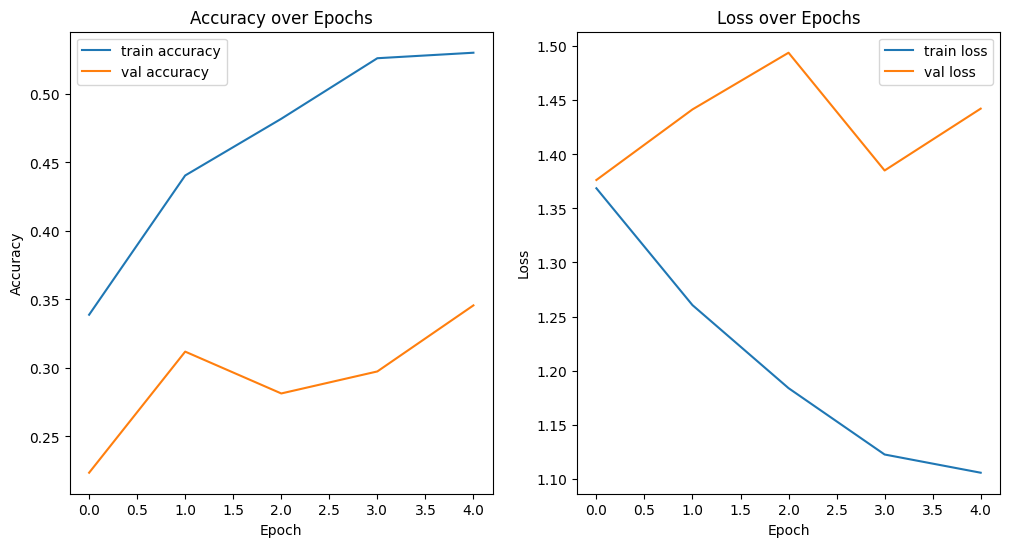

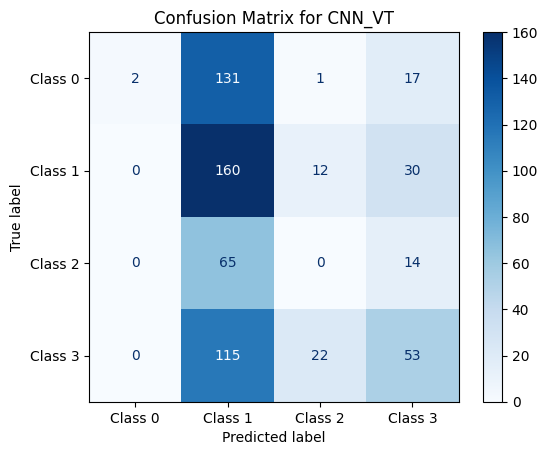

In [4]:
# Loop over each dataset split ('train' and 'val') and print out accuracies and losses for each epoch.
for split in ['train', 'val']:
    # Print the accuracies for each epoch. The `accuracies` dictionary likely contains lists of accuracies per epoch for each split.
    print(split, 'accuracies by epoch:', accuracies[split])
    # Print the losses for each epoch. The `losses` dictionary similarly contains lists of losses per epoch for each split.
    print(split, 'losses by epoch:', losses[split])

# Save the trained model's state dictionary to a file. This allows the model to be re-loaded later with the exact same parameters.
torch.save(model_ft.state_dict(), '../../models/CNN_VT_best_model.pt')

# Call a function to plot the training history.
# This function likely generates plots of accuracies and losses over the epochs, providing a visual representation of the training process.
plot_training_history(accuracies, losses, 'CNN_VT')

# Call a function to plot a confusion matrix.
# The confusion matrix compares the labels predicted by the model against the true labels,
# providing insight into how well the model is performing across different classes.
plot_confusion_matrix(labels, preds, 'CNN_VT')